# HW3: ArcGIS Geoenrichment and Machine Learning

In this set of exercises, we will work through several typical steps in machine learning over spatial data, from feature engineering, to data exploration, data preparation for machine learning, running two or more maching learning models, and analysis of results. This lab will be a bit more open ended than your previous labs. On the technical side, we will explore several ArcGIS tools that support feature engineering, the process of creating columns in your data table that you will use as independent variables in your model.

Substantially, we will build a model to predict COVID-19 infection risks (COVID-19 rates) by school service areas, based on zip code data. Predicting such risks is important because transmission of COVID in schools "depends on the local transmission rates; the types of variants circulating; the epidemiology of COVID-19 among children, adolescents, and staff; vaccine coverage for those eligible; and mitigation measures in place to prevent transmission.” (https://www.cdc.gov/coronavirus/2019-ncov/science/science-briefs/transmission_k_12_schools.html)


The steps in building the model will include:

 1. construct a spatially-enabled dataframe where rows represent zip codes, and the columns include variables that affect COVID-19 rates. Some variables will be retrieved from San Diego County ArcGIS services, and others will be obtained through geoenrichment
 2. explore relationships between the variables, clean up the dataframe, scale variables as needed 
 3. split the dataset into training and testing data, and perform regression modeling using at least two machine learning models of your choice
 4. examine the model, keep only the essential variables, rerun it as needed 
 5. construct a spatially-enabled dataframe of "school service areas", for a selected subset of schools
 6. geoenrich the dataframe of school service areas, using the same variables you retained after examining variable significance
 7. apply the best performing model to the school service areas, and produce a map showing the predicted COVID charactceristics by these areas 
 
For these steps, we will provide initial code while you will do the rest, justify your programming and modeling choices, and explain the results.


**Due Date: 5/12/2022 11:59PM (Pacific Time)**

**Total Possible Points : 110 pts**

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor # this is a component for working with SEDF
import pandas as pd
import geopandas as gpd
from arcgis.features import FeatureLayerCollection

# you need to be logged in to use geoenrichment and service area calculation:

# gis = GIS(username='jil1119_UCSDOnline') 
gis = GIS(username='gp490sp22_2') 

Enter password: ········


In [2]:
data_location = "/datasets/gpgn490-sp22-g00-public/"

## Step 1. Constructing a SEDF by Zip Codes

(15 points; follow prompts in CAPITAL LETTERS; This is where your additions (code, text) are expected)

The spatially-enabled data frame (SEDF) will be constructed in two steps: by exploring available ArcGIS services and retrieving variables from them that we could use in the model, and via geoenrichment. Remember that we need to include a target variable (such as positive case rate) and a set of independent variables. These independent variables should be available by both zip codes and by school service areas, so that we can apply the model built for zip codes, to service areas. 

### 1.1 ArcGIS Services with current county data

San Diego County relies on ArcGIS for regional and municipal management across departments. It publishes a number of ArcGIS services which are publicly accessible.

Some key service collections include:

 - https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted

 - https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/

Among these services, you may find COVID cases by zip code, including weekly rates and changes, and % positivity: https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/CaseRateZIPs_MainDash_PUBLIC_VIEW/FeatureServer. 


Another service with relevant data is:

- https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/Covid19_San_Diego_County_PUBLIC_VIEW/FeatureServer
(here, the first layer shows information by zip codes).

Yet another one is:

 - https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID19_CaseRateData/FeatureServer
(here, the second server has zip code-level data)

Please explore the content of other services that you feel may help you with the analysis. 

Later, when we get to step 5, we will also look at ArcGIS services published by the state of California, to retrieve information about schools.

We recommend that you explore such services from the County and from the State of California because they may provide useful data sources for your projects. Some CA-wide services are at 

 - https://services2.arcgis.com/wi1yEacfYjH5viqb/ArcGIS/rest/services (the public health collection, including vaccination locations)

 - https://services3.arcgis.com/fdvHcZVgB2QSRNkL/arcgis/rest/services (education-related services)
 
 (If you end up using these data, make sure you perform projection conversions as needed.)


These services underly a number of ArcGIS-based portals and dashboards, where you can view the same data. For example, explore the CA State Geoportal at https://gis.data.ca.gov/search?q=school, and San Diego City and County Open Data Portals https://data.sandiego.gov/ and https://sdgis-sandag.opendata.arcgis.com/. (in fact, we discovered these underlying services by analyzing network traffic to these portals with an open source tool called Fiddler, https://www.telerik.com/fiddler). )

In [3]:
# import feature collection component of ArcGIS Python API - we need this to query services
from arcgis.features import FeatureLayerCollection

In [4]:
# Let's explore one of the services together. You will explore another service yourself.

# Here is how you can retrieve data from this first service into a SEDF: 

serviceURL =  'https://services1.arcgis.com/1vIhDJwtG5eNmiqX/ArcGIS/rest/services/Covid19_San_Diego_County_PUBLIC_VIEW/FeatureServer'
item = FeatureLayerCollection(serviceURL, gis=gis)
sedf_zip1 = pd.DataFrame.spatial.from_layer(item.layers[0]) # using the first layer in this service

In [5]:
# View the content of the SEDF
sedf_zip1

,Case_Count,OBJECTID,SDEP_SANGIS_ZIPCODE_ZIP,SHAPE,UpdateDate,ZipText,Zip_Code,rate_100k
0,8.0,42069,91902,"{""x"": -13026057.7471, ""y"": 3851792.785700001, ...",2020-03-31 08:00:00,91902,91902,NaN
1,17.0,42070,91910,"{""x"": -13031688.9139, ""y"": 3847142.7708000015,...",2020-03-31 08:00:00,91910,91910,NaN
2,13.0,42071,91911,"{""x"": -13029970.2467, ""y"": 3843296.065300002, ...",2020-03-31 08:00:00,91911,91911,NaN
3,14.0,42072,91913,"{""x"": -13022988.3334, ""y"": 3844479.949199997, ...",2020-03-31 08:00:00,91913,91913,NaN
4,2.0,42073,91914,"{""x"": -13017239.4424, ""y"": 3850787.6198000014,...",2020-03-31 08:00:00,91914,91914,NaN
...,...,...,...,...,...,...,...,...
53536,65.0,96838,92155,"{""x"": -13042302.1807, ""y"": 3852142.174800001, ...",2022-05-02 08:00:00,92155,None,NaN
53537,13103.0,96839,92173,"{""x"": -13029669.526700001, ""y"": 3836284.149700...",2022-05-02 08:00:00,92173,None,48355.9
53538,153.0,96840,92182,"{""x"": -13032541.3375, ""y"": 3865633.436300002, ...",2022-05-02 08:00:00,92182,None,NaN
53539,16.0,96841,92536,"{""x"": -12993271.8212, ""y"": 3948341.898699999, ...",2022-05-02 08:00:00,92536,None,NaN


Notice that this service presents time series of COVID case counts and rates, from 3/31/2020 to present. 

Counting COVID tests, and computing posititivity, is now harder because of the proliferation of home test kits, since mid-January (https://www.whitehouse.gov/briefing-room/statements-releases/2022/01/14/fact-sheet-the-biden-administration-to-begin-distributing-at-home-rapid-covid-19-tests-to-americans-for-free/). Therefore, we will look at COVID severety by zip codes from early January 2022. Let's use a fragment of the data frame, with Update Date of 1/11/2022. That was during the Omicron surge.


In [6]:
# Subset for the selected date:

filterselect  = sedf_zip1.UpdateDate == "2022-01-11 08:00:00"
sedf_zip1_filtered = sedf_zip1[filterselect]

In [7]:
# using this construct will let you see all rows:

with pd.option_context("display.max_rows", None):
    display(sedf_zip1_filtered)

,Case_Count,OBJECTID,SDEP_SANGIS_ZIPCODE_ZIP,SHAPE,UpdateDate,ZipText,Zip_Code,rate_100k
51671,2678.0,94643,91901,"{""x"": -12990487.759100001, ""y"": 3869543.480999...",2022-01-11 08:00:00,91901,91901,14889.4
51672,2868.0,94644,91902,"{""x"": -13026057.7471, ""y"": 3851792.785700001, ...",2022-01-11 08:00:00,91902,91902,16266.8
51673,156.0,94645,91905,"{""x"": -12947065.5585, ""y"": 3857981.0508999974,...",2022-01-11 08:00:00,91905,91905,NaN
51674,633.0,94646,91906,"{""x"": -12965345.532, ""y"": 3850317.6274999976, ...",2022-01-11 08:00:00,91906,91906,NaN
51675,16628.0,94647,91910,"{""x"": -13031688.9139, ""y"": 3847142.770800002, ...",2022-01-11 08:00:00,91910,91910,19834.4
51676,19295.0,94648,91911,"{""x"": -13029970.2467, ""y"": 3843296.0653000027,...",2022-01-11 08:00:00,91911,91911,22748.4
51677,9985.0,94649,91913,"{""x"": -13022988.3334, ""y"": 3844479.949199997, ...",2022-01-11 08:00:00,91913,91913,19548.9
51678,2944.0,94650,91914,"{""x"": -13017239.442400001, ""y"": 3850787.619800...",2022-01-11 08:00:00,91914,91914,17543.7
51679,5739.0,94651,91915,"{""x"": -13015603.514800001, ""y"": 3844612.3332, ...",2022-01-11 08:00:00,91915,91915,18442.1
51680,215.0,94652,91916,"{""x"": -12981032.6672, ""y"": 3882212.1389999986,...",2022-01-11 08:00:00,91916,91916,NaN


In [8]:
# explore the dimensions of the table

sedf_zip1_filtered.shape

(110, 8)

In [9]:
# Notice that case counts and rates are not available for all zip codes.
# Some have NaN (Not a Number) instead of the actual values.
# Let's remove those zip codes with missing data

sedf_zip1_filtered_nonNAN = sedf_zip1_filtered[sedf_zip1_filtered['rate_100k'].notna()]


In [10]:
# Explore the dimensions of the new table, after rows of missing case rates have been excluded:

sedf_zip1_filtered_nonNAN.shape


(78, 8)

In [11]:
# We ended up with 78 zip codes to build our model. Explore the table:

with pd.option_context("display.max_rows", None):
    display(sedf_zip1_filtered_nonNAN)

,Case_Count,OBJECTID,SDEP_SANGIS_ZIPCODE_ZIP,SHAPE,UpdateDate,ZipText,Zip_Code,rate_100k
51671,2678.0,94643,91901,"{""x"": -12990487.759100001, ""y"": 3869543.480999...",2022-01-11 08:00:00,91901,91901,14889.4
51672,2868.0,94644,91902,"{""x"": -13026057.7471, ""y"": 3851792.785700001, ...",2022-01-11 08:00:00,91902,91902,16266.8
51675,16628.0,94647,91910,"{""x"": -13031688.9139, ""y"": 3847142.770800002, ...",2022-01-11 08:00:00,91910,91910,19834.4
51676,19295.0,94648,91911,"{""x"": -13029970.2467, ""y"": 3843296.0653000027,...",2022-01-11 08:00:00,91911,91911,22748.4
51677,9985.0,94649,91913,"{""x"": -13022988.3334, ""y"": 3844479.949199997, ...",2022-01-11 08:00:00,91913,91913,19548.9
51678,2944.0,94650,91914,"{""x"": -13017239.442400001, ""y"": 3850787.619800...",2022-01-11 08:00:00,91914,91914,17543.7
51679,5739.0,94651,91915,"{""x"": -13015603.514800001, ""y"": 3844612.3332, ...",2022-01-11 08:00:00,91915,91915,18442.1
51683,4777.0,94655,91932,"{""x"": -13037725.1108, ""y"": 3839068.1191999987,...",2022-01-11 08:00:00,91932,91932,17403.8
51686,5222.0,94658,91941,"{""x"": -13024079.916000001, ""y"": 3864460.578000...",2022-01-11 08:00:00,91941,91941,15257.9
51687,5561.0,94659,91942,"{""x"": -13026966.773400001, ""y"": 3865929.282300...",2022-01-11 08:00:00,91942,91942,13893.5


### Repeat this process for another service. We will then compare the resultant dataframes



In [13]:
# The second service we'll use is:  

serviceURL = 'https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/COVID19_CaseRateData/FeatureServer'

# CREATE A SEDF FROM THE SECOND LAYER IN THIS SERVICE, NAME IT sedf_zip2

item = FeatureLayerCollection(serviceURL, gis=gis)
sedf_zip2 = pd.DataFrame.spatial.from_layer(item.layers[1]) 

In [14]:
# This service also represents time series of positive case counts and several derived variables.
# Let's get only rows that correspond with the week "1/9/2022-1/15/2022". 

# the filtering condition, therefore, will be: sedf_zip2.current_date_range == "1/9/2022-1/15/2022"

# CREATE A SUBSET OF sedf_zip2 FOR THE GIVEN DATE RANGE, AND NAME IT sef_zip2_filtered

filterselect  = sedf_zip2.current_date_range == "1/9/2022-1/15/2022"
sedf_zip2_filtered = sedf_zip2[filterselect]


In [15]:
# HOW MANY ZIP CODES ARE IN THIS TABLE? 
sedf_zip2_filtered.shape
# There are 84 zip codes in this table. 


(84, 17)

In [16]:
# EXPLORE THE FILTERED TABLE
sedf_zip2_filtered


,SHAPE,current_date_range,f7_day_average_case_rate,globalid,new_cases_in_7_day_case_rate,notes,objectid,population,positive_tests_in_7_day_testing,previous_week_case_rate,previous_week_date_range,testing_positivity_percentage,total_cases,total_tests_in_7_day_testing_po,zip,zip_code,zip_text_comb
5124,"{""rings"": [[[-12996038.8672, 3890080.229400001...",1/9/2022-1/15/2022,147.733952,{B62582EA-0FE2-40F4-BEA1-709E7DF0EC47},186.0,None,6143,17986.0,197.0,232.720688,1/2/2022-1/8/2022,0.249052,3055.0,791.0,NaN,91901,None
5125,"{""rings"": [[[-13021233.214, 3856660.4949999973...",1/9/2022-1/15/2022,240.647561,{641F9FB1-3331-4196-AE5F-842AA1E5BD65},297.0,None,6144,17631.0,337.0,337.878898,1/2/2022-1/8/2022,0.318827,3378.0,1057.0,NaN,91902,None
5126,"{""rings"": [[[-12970584.6025, 3883349.538599997...",1/9/2022-1/15/2022,248.756219,{EB776D22-AF38-442D-A3D7-1A03C72F96E8},168.0,None,6145,9648.0,185.0,269.485904,1/2/2022-1/8/2022,0.394456,1829.0,469.0,NaN,91905 & 91906 & 91934 & 91962 & 91963 & 91980,None
5127,"{""rings"": [[[-13031455.2456, 3848954.227799996...",1/9/2022-1/15/2022,309.966294,{2B29B3E1-A458-45CA-9C37-DECBD85C83AF},1819.0,None,6146,83834.0,2329.0,387.159659,1/2/2022-1/8/2022,0.334578,19822.0,6961.0,NaN,91910,None
5128,"{""rings"": [[[-13029547.799800001, 3846091.4715...",1/9/2022-1/15/2022,372.558035,{A65D37AE-3AF6-4655-AB7A-73B2DA95FD48},2212.0,None,6147,84819.0,2441.0,402.537841,1/2/2022-1/8/2022,0.373013,23112.0,6544.0,NaN,91911,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5203,"{""rings"": [[[-13047399.1645, 3892534.201800003...",1/9/2022-1/15/2022,183.249732,{9B032258-AE54-46B0-ADC6-705E792031E2},826.0,None,6222,64393.0,972.0,246.033841,1/2/2022-1/8/2022,0.211626,6648.0,4593.0,NaN,92121 & 92130,None
5204,"{""rings"": [[[-13031628.8531, 3838249.686499998...",1/9/2022-1/15/2022,509.281470,{F22D4505-1217-4F5C-85A9-9DAEE98C61CE},966.0,None,6223,27097.0,1011.0,433.890942,1/2/2022-1/8/2022,0.372239,11111.0,2716.0,NaN,92173,None
5205,"{""rings"": [[[-13050542.5743, 3880716.543399997...",1/9/2022-1/15/2022,338.811631,{BE1C42D7-F12A-47B0-92D6-34BC37D26398},268.0,None,6224,11300.0,347.0,561.314791,1/2/2022-1/8/2022,0.260511,1316.0,1332.0,NaN,92093 & 92161,None
5206,"{""rings"": [[[-13018754.062199999, 3853132.1893...",1/9/2022-1/15/2022,284.335175,{9E67A875-2DB7-4196-B3BB-E51B51999413},334.0,None,6225,16781.0,343.0,377.978496,1/2/2022-1/8/2022,0.294421,3508.0,1165.0,NaN,91914,None


You'll notice that, in this case, the authors of the service used a different approach to show data for smaller zip codes, where the values are below a reporting threshold. Instead of suppressing reported low values, here they clumped several smaller zip codes together. To generate a clean table where each record represents a single zip code, we could re-allocate absolute counts shown by groups of zip codes using zip code population. However, for simplicity we'll just remove those clumps of zip codes.

In [18]:
# remove clumps of zip codes
sedf_zip2_filtered_noclumps = sedf_zip2_filtered[sedf_zip2_filtered['zip_code'].str.isdigit()]

EXPLAIN WHAT THIS CODE DOES:

Answer: This code isolates where the string is only a numerical digit, which would exclude the '&' symbol. Then it subsets based on this filter. 



In [19]:
# HOW MANY ZIP CODE RECORDS DO WE HAVE IN sedf_zip2_filtered_noclumps?
sedf_zip2_filtered_noclumps.shape
# We have 67 zip codes. 

(67, 17)

In [20]:
# EXPLORE THE sedf_zip2_filtered_noclumps
sedf_zip2_filtered_noclumps

,SHAPE,current_date_range,f7_day_average_case_rate,globalid,new_cases_in_7_day_case_rate,notes,objectid,population,positive_tests_in_7_day_testing,previous_week_case_rate,previous_week_date_range,testing_positivity_percentage,total_cases,total_tests_in_7_day_testing_po,zip,zip_code,zip_text_comb
5124,"{""rings"": [[[-12996038.8672, 3890080.229400001...",1/9/2022-1/15/2022,147.733952,{B62582EA-0FE2-40F4-BEA1-709E7DF0EC47},186.0,None,6143,17986.0,197.0,232.720688,1/2/2022-1/8/2022,0.249052,3055.0,791.0,NaN,91901,None
5125,"{""rings"": [[[-13021233.214, 3856660.4949999973...",1/9/2022-1/15/2022,240.647561,{641F9FB1-3331-4196-AE5F-842AA1E5BD65},297.0,None,6144,17631.0,337.0,337.878898,1/2/2022-1/8/2022,0.318827,3378.0,1057.0,NaN,91902,None
5127,"{""rings"": [[[-13031455.2456, 3848954.227799996...",1/9/2022-1/15/2022,309.966294,{2B29B3E1-A458-45CA-9C37-DECBD85C83AF},1819.0,None,6146,83834.0,2329.0,387.159659,1/2/2022-1/8/2022,0.334578,19822.0,6961.0,NaN,91910,None
5128,"{""rings"": [[[-13029547.799800001, 3846091.4715...",1/9/2022-1/15/2022,372.558035,{A65D37AE-3AF6-4655-AB7A-73B2DA95FD48},2212.0,None,6147,84819.0,2441.0,402.537841,1/2/2022-1/8/2022,0.373013,23112.0,6544.0,NaN,91911,None
5129,"{""rings"": [[[-13021187.1937, 3848402.699600003...",1/9/2022-1/15/2022,321.083854,{0EBE28C6-36C5-4B33-950C-80CC1A5F9D0B},1148.0,None,6148,51077.0,1207.0,425.687827,1/2/2022-1/8/2022,0.306968,11942.0,3932.0,NaN,91913,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201,"{""rings"": [[[-13035374.4407, 3843522.323399998...",1/9/2022-1/15/2022,412.520626,{9B91EA3B-9421-4E4E-AA8C-89EE2398F062},2310.0,None,6220,79996.0,2926.0,442.522126,1/2/2022-1/8/2022,0.378281,24432.0,7735.0,NaN,92154,None
5202,"{""rings"": [[[-13048210.317400001, 3878401.7571...",1/9/2022-1/15/2022,149.837456,{B9D02812-E3C9-456F-A17C-ECD039CB3790},454.0,None,6221,43285.0,513.0,285.153220,1/2/2022-1/8/2022,0.162805,4772.0,3151.0,NaN,92037,None
5204,"{""rings"": [[[-13031628.8531, 3838249.686499998...",1/9/2022-1/15/2022,509.281470,{F22D4505-1217-4F5C-85A9-9DAEE98C61CE},966.0,None,6223,27097.0,1011.0,433.890942,1/2/2022-1/8/2022,0.372239,11111.0,2716.0,NaN,92173,None
5206,"{""rings"": [[[-13018754.062199999, 3853132.1893...",1/9/2022-1/15/2022,284.335175,{9E67A875-2DB7-4196-B3BB-E51B51999413},334.0,None,6225,16781.0,343.0,377.978496,1/2/2022-1/8/2022,0.294421,3508.0,1165.0,NaN,91914,None


__After this step, we have two SEDF's with zip code data reflecting COVID-19 severity by zip codes:__

 - __sedf_zip1_filtered_nonNAN__, with 78 zip codes.   
 
     - The variable we are interested in is rate_100k. 
     - The zip code column is called Zip_Code
     
 - __sedf_zip2_filtered_noclumps__, with "X" zip codes.   
 
     - The variable we are interested in is testing_positivity_percentage. 
     - The zip code column is called zip_code.

### 1.2 Geoenrich the zip codes


In [21]:
# import the geoenrichment component of ArcGIS Python API
from arcgis.geoenrichment import *



As before, we will start with the first service (i.e. the SEDF named __sedf_zip1_filtered_nonNAN__)

As input into a geoenrichment request, we will need to specify two lists: __study_areas__, and __analysis_variables__.

__Study areas__ can be specified in several ways. 

a) Extract zip codes from the SEDF into a list. In pandas terms, we will convert a pandas series into a list, then use a list of zip codes as study_areas.

b) Generate zip code "named areas" based on zip5 information available for each state in the geoenrichment service.

c) Use the SEDF itself to define study areas.

Let's explore these approaches, and note the differences.


In [22]:
# option a): converting a pandas series into a list of zip codes

zips1 = sedf_zip1_filtered_nonNAN['Zip_Code'].to_list()
study_areas_a = zips1

In [23]:
# option b). Generating a list of named areas based on a list of zip codes
usa = Country.get('US')

study_areas_list1 = []
for z in zips1:
    zip_sa = usa.subgeographies.states['California'].zip5[z]
    study_areas_list1.append(zip_sa)

study_areas_b = study_areas_list1

In [24]:
# option c): using the SEDF directly

study_areas_c = sedf_zip1_filtered_nonNAN

In [25]:
# let's run geoenrichment on a few common variables, and compare the study areas we generate:

analysis_variables = [
    'TOTPOP_CY',  # Population: Total Population (Esri)
    'DIVINDX_CY', # Diversity Index (Esri)
    'AVGHHSZ_CY', # Average Household Size (Esri)
    'MEDAGE_CY',  # Age: Median Age (Esri)
    'MEDHINC_CY', # Income: Median Household Income (Esri)
    'BACHDEG_CY', # Education: Bachelor's Degree (Esri)
]


In [26]:
enrich_a = enrich(study_areas=study_areas_a, analysis_variables=analysis_variables)
enrich_a

,ID,OBJECTID,sourceCountry,X,Y,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP_CY,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,BACHDEG_CY,SHAPE
0,0,1,US,-116.771728,32.836349,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,6505,56.5,2.52,38.5,78071,1159,"{""rings"": [[[-116.7717282, 32.85086067762614],..."
1,1,2,US,-117.024548,32.675556,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,12701,87.2,3.09,39.5,100738,1988,"{""rings"": [[[-117.02454829999998, 32.690067550..."
2,2,3,US,-117.084650,32.637515,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,35264,81.8,2.73,35.3,46993,3178,"{""rings"": [[[-117.08464999999995, 32.652026938..."
3,3,4,US,-117.079925,32.613500,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,31432,81.3,3.17,33.2,52869,1992,"{""rings"": [[[-117.07992499999995, 32.628011994..."
4,4,5,US,-116.979155,32.627645,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,27407,86.4,3.44,33.1,108558,5309,"{""rings"": [[[-116.97915499999999, 32.642156961..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,73,74,US,-117.090485,32.932535,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,14859,65.4,2.99,37.3,145822,3759,"{""rings"": [[[-117.09048499999994, 32.947046254..."
74,74,75,US,-117.124030,32.683810,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,16298,87.8,4.09,24.7,42273,764,"{""rings"": [[[-117.12402999999995, 32.698321831..."
75,75,76,US,-117.060954,32.677720,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,28301,89.5,3.54,34.7,65550,2938,"{""rings"": [[[-117.06095419999997, 32.692231845..."
76,76,77,US,-117.095430,32.579340,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,32102,84.1,3.30,32.4,53350,2471,"{""rings"": [[[-117.09542999999996, 32.593852073..."


In [27]:
enrich_b = enrich(study_areas=study_areas_b, analysis_variables=analysis_variables)
enrich_b

,ID,OBJECTID,StdGeographyLevel,StdGeographyName,StdGeographyID,sourceCountry,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP_CY,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,BACHDEG_CY,SHAPE
0,0,1,US.ZIP5,Alpine,91901,US,Query:US.ZIP5,2.191,2.576,1,17902,49.8,2.67,45.2,103208,2890,"{""rings"": [[[-116.76307000036512, 32.978439999..."
1,1,2,US.ZIP5,Bonita,91902,US,Query:US.ZIP5,2.191,2.576,1,17417,80.2,2.94,44.6,105293,3301,"{""rings"": [[[-116.9690102183506, 32.7075649441..."
2,2,3,US.ZIP5,Chula Vista,91910,US,Query:US.ZIP5,2.191,2.576,1,77980,82.8,2.90,37.0,69388,9945,"{""rings"": [[[-117.04375999972943, 32.658169999..."
3,3,4,US.ZIP5,Chula Vista,91911,US,Query:US.ZIP5,2.191,2.576,1,86716,82.4,3.40,34.7,62811,7805,"{""rings"": [[[-117.04389000032407, 32.629019999..."
4,4,5,US.ZIP5,Chula Vista,91913,US,Query:US.ZIP5,2.191,2.576,1,56072,86.3,3.44,34.0,106826,10304,"{""rings"": [[[-116.97928000032546, 32.661529999..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,73,74,US.ZIP5,San Diego,92131,US,Query:US.ZIP5,2.191,2.576,1,37500,61.9,2.91,39.8,145321,9542,"{""rings"": [[[-117.0954199997799, 32.9428299998..."
74,74,75,US.ZIP5,San Diego,92136,US,Query:US.ZIP5,2.191,2.576,1,8419,79.3,0.00,23.9,0,567,"{""rings"": [[[-117.12541000041867, 32.690799999..."
75,75,76,US.ZIP5,San Diego,92139,US,Query:US.ZIP5,2.191,2.576,1,37095,89.1,3.39,34.6,69225,4360,"{""rings"": [[[-117.0275099999575, 32.6978299997..."
76,76,77,US.ZIP5,San Diego,92154,US,Query:US.ZIP5,2.191,2.576,1,88487,86.2,3.72,34.1,70792,8508,"{""rings"": [[[-116.90458625675235, 32.626104488..."


In [28]:
enrich_c = enrich(study_areas=study_areas_c, analysis_variables=analysis_variables)
enrich_c

,ID,OBJECTID_0,sourceCountry,OBJECTID,rate_100k,UpdateDate,ZipText,Case_Count,Zip_Code,SDEP_SANGIS_ZIPCODE_ZIP,...,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP_CY,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,BACHDEG_CY,SHAPE
0,0,1,US,94643,14889.4,1641916800000,91901,2678,91901,91901,...,2.191,2.576,1,6,61.4,5.00,57.5,0.0,1.0,"{""rings"": [[[-116.69553702167083, 32.820221255..."
1,1,2,US,94644,16266.8,1641916800000,91902,2868,91902,91902,...,2.191,2.576,1,7890,80.6,2.97,45.0,109848.0,1496.0,"{""rings"": [[[-117.0150676604343, 32.6860947981..."
2,2,3,US,94647,19834.4,1641916800000,91910,16628,91910,91910,...,2.191,2.576,1,22006,79.0,2.78,38.5,67153.0,2687.0,"{""rings"": [[[-117.06565329247294, 32.650925357..."
3,3,4,US,94648,22748.4,1641916800000,91911,19295,91911,91911,...,2.191,2.576,1,30733,80.6,3.59,35.8,61712.0,2399.0,"{""rings"": [[[-117.05021424233222, 32.621821131..."
4,4,5,US,94649,19548.9,1641916800000,91913,9985,91913,91913,...,2.191,2.576,1,27714,86.3,3.50,33.0,111124.0,5265.0,"{""rings"": [[[-116.98749464803434, 32.630779420..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,75,US,94743,2393.7,1641916800000,92136,299,92136,92136,...,2.191,2.576,1,15252,83.6,4.91,24.1,41659.0,910.0,"{""rings"": [[[-117.12491279458703, 32.694122184..."
75,75,76,US,94744,20519.4,1641916800000,92139,6827,92139,92139,...,2.191,2.576,1,29547,87.7,3.32,34.7,70529.0,3630.0,"{""rings"": [[[-117.04900507223056, 32.694567399..."
76,76,77,US,94747,28166.4,1641916800000,92154,22532,92154,92154,...,2.191,2.576,1,96,81.3,3.00,32.1,100000.0,12.0,"{""rings"": [[[-116.9818162776475, 32.5790329366..."
77,77,78,MX,94749,34778.8,1641916800000,92173,9424,92173,92173,...,3.040,2.810,1,1255,NaN,2.60,NaN,NaN,NaN,"{""rings"": [[[-117.04751282860981, 32.568744544..."


### EXPLAIN THE DIFFERENCE IN GEOENRICHMENT RESULTS

COMPARE THE THREE APPROACHES TO CONSRUCTING STUDY AREAS, SELECT ONE OF THEM AND EXPLAIN YOUR CHOICE:



Option a takes a list of zip codes from the data frame and enriches based that zip code. Option b assigns a city to the zip code contained in the dataset provided through ArcGIS. Option c takes the available shapefile with covid rates included and enriches based on the SHAPE column. I chose option B in the subsequent enriches because it includes both the zip codes and city names, and this may be useful. 

Next, let's figure out which variables to use in our model. In terms of geoenrichment, these will form another list, to be used as __analysis_variables__.

We can hypothesize that people have a higher chance to catch the virus if they interact with more people, and have fewer resources to stay COVID-safe. For example, if they don't work from home but need to go to their workplace every day, if they are engaged in sales or services occupations, if they have to take public transportation to work. If people don't have medical insurance, they may tend to avoid or postpone testing. There may be other factors that you can think about, such as household composition (the larger the household, the higher the potential for catching the virus from other household members.) All these characteristics describe various populations at risk for COVID infection. These variables (and many more) can be found in census data, in particular in the American Community Survey - and they can also be obtained through geoenrichment. 

Altogether, let's have at least 10 variables in our list of analysis variables by zip codes. Besides the variables listed above, you may consider the following variables available via geoenrichment from the following collections. These are merely suggestions: don't feel obligated to use them all, and don't feel limited to these variables either. Please explore other variables using techniques shown in the lecture.
```
Data collection: "Health"
Health.ACS0NOHI      2019 Pop <19: No Health Insurance (ACS 5-Yr)
Health.ACS19NOHI     2019 Pop 19-34: No Health Insurance (ACS 5-Yr)     
Health.ACS35NOHI     2019 Pop 35-64: No Health Insurance (ACS 5-Yr)
Health.ACS65NOHI     2019 Pop 65+: No Health Insur (ACS 5-Yr)
Health.MEDHINC_CY    2021 Median Household Income     2021 Income (Esri)     2021
Health.MEDAGE_CY     2021 Median Age     2021 Age: 5 Year Increments (Esri)     2021
```

```
Data collection: "EmploymentUnemployment"
EmploymentUnemployment.UNEMPRT_CY     2021 Unemployment Rate     2021 Labor Force (Esri)     2021
```

```
Data collection:"householdincome"
householdincome.MEDHINC_CY     2021 Median Household Income     2021 Income (Esri)     2021
householdincome.AVGHINC_CY     2021 Average Household Income     2021 Income (Esri)     2021
```

```
Data collection: "InternetComputerUsage"
InternetComputerUsage.ACSU18NOPC     2019 HH Pop <18: No Computer (ACS 5-Yr)     2015-2019 Computer and Internet Service (ACS)     2015-2019
InternetComputerUsage.ACS18NOPC      2019 HH Pop 18-64: No Computer (ACS 5-Yr)     2015-2019 Computer and Internet Service (ACS)     2015-2019
InternetComputerUsage.ACSNETBBND     2019 HHs w/Internet:Broadband (ACS 5-Yr)     2015-2019 Computer and Internet Service (ACS)     2015-2019
InternetComputerUsage.ACSNONET       2019 HHs w/No Internet Access (ACS 5-Yr)     2015-2019 Computer and Internet Service (ACS)     2015-2019
```

```
Data collection: "AtRisk"
AtRisk.ACSSNAP     2019 HHs w/Food Stamps/SNAP (ACS 5-Yr)     2015-2019 Income (ACS)     2015-2019
AtRisk.PACSHHBPOV     2019 Percent of HHs with Income Below Poverty ...     2015-2019 Household Income (ACS)     2015-2019
AtRisk.PACSOVEH0     2019 Owner Households with no vehicles availab...     2015-2019 Households by Vehicles Available (ACS)     2015-2019
```


```
Data collection: "commute"
commute.ACSPUBTRAN     2019 Workers 16+: Public Transportation (ACS 5...     2015-2019 Journey to Work (ACS)     2015-2019
commute.ACSWRKHOME     2019 Wrkrs 16+: Worked at Home (ACS 5-Yr)     2015-2019 Journey to Work (ACS)     2015-2019
```

```
Data collection: "occupation"
occupation.OCCENT_CY     2021 Occupation: Arts/Entertainment/Rec     2021 Labor Force (Esri)     2021
occupation.OCCHTCH_CY     2021 Occupation: Health Practices     2021 Labor Force (Esri)     2021
occupation.OCCFOOD_CY     2021 Occupation: Food Preparation     2021 Labor Force (Esri)     2021
occupation.OCCBLDG_CY     2021 Occupation: Building Maintenance     2021 Labor Force (Esri)     2021
occupation.OCCPERS_CY     2021 Occupation: Personal Care     2021 Labor Force (Esri)     2021
occupation.OCCSALE_CY     2021 Occupation: Sales     2021 Labor Force (Esri)     2021
occupation.OCCMAIN_CY     2021 Occupation: Maintenance/Repair     2021 Labor Force (Esri)     2021
occupation.OCCPROD_CY     2021 Occupation: Production     2021 Labor Force (Esri)     2021
occupation.OCCTRAN_CY     2021 Occupation: Transportation/Moving     2021 Labor Force (Esri)     2021
```

And a few additional politics- and health-related variables for you to consider:

```
CivicActivitiesPoliticalAffiliation.MP06025A_I: Affiliated with Republican political party, Index (index is a ratio of local rate to US rate)
CivicActivitiesPoliticalAffiliation.MP06024A_I: Affiliated with Democratic political party, Index.
HealthPersonalCare.MP14088A_I: 2021 Used Asthma Prescription Drug, Index
HealthPersonalCare.MP14056A_I: 2021 Visited Cardiologist Doctor last 12 mo, Index
```

__You may find it easier to use the ESRI Demographics Data Browser at https://doc.arcgis.com/en/esri-demographics/data/data-browser.htm than to discover variables through code. See https://support.esri.com/en/technical-article/000023253 for details.__







### DOCUMENT YOUR VARIABLE SELECTION.

`YOUR JUSTIFICATION FOR THE VARIABLES SELECTED FOR YOUR MODEL:`


'KeyUSFactsPL94.BLACK20' I included this variable to explore whether racial makeup affects COVID rates. This is based on my understanding of research which shows minority communities have disporportionally higher COVID rates.  

I removed the ACSSNAP variable because it will be closely linked with poverty, for which we already include various measures. I also removed ACSNONET because it will be highly correlated with the variable ACS18NOPC.

In [29]:
# using these variables, you can build the analysis_variables list, for example

analysis_variables = [
    'TOTPOP_CY', 
    'DIVINDX_CY', 
    'AVGHHSZ_CY', 
    'MEDAGE_CY',  
    'MEDHINC_CY', 
    'BACHDEG_CY', 
    'ACS0NOHI',
    'ACS19NOHI',
    'ACS35NOHI',
    'UNEMPRT_CY',
    'ACS18NOPC',
    'ACSPUBTRAN',
    'KeyUSFactsPL94.BLACK20'
]

# NOTE: THE ABOVE IS MERELY AN EXAMPLE OF A LIST OF VARIABLES WE CAN USE FOR MODELING!
# TOTPOP is included because we'll need to divide some counts by total population

In [31]:
# Now, let's create a SEDF with geoenrichment results, using the study_areas and analysis_variables defined earlier
# make sure you use the study_areas you selected and justified earlier in section 1.2.


# ENRICH THE SELECTED STUDY AREAS USING YOUR SELECTED VARIABLES, NAME THE RESULTANT SEDF 'enrich_by_zip'
enrich_by_zip5 = enrich(study_areas = study_areas_b, analysis_variables = analysis_variables)

In [32]:
# EXPLORE THE RESULTS
enrich_by_zip5

,ID,OBJECTID,StdGeographyLevel,StdGeographyName,StdGeographyID,sourceCountry,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,...,MEDHINC_CY,BACHDEG_CY,ACS0NOHI,ACS19NOHI,ACS35NOHI,UNEMPRT_CY,ACS18NOPC,ACSPUBTRAN,BLACK20,SHAPE
0,0,1,US.ZIP5,Alpine,91901,US,Multiple methods,2.191,2.576,1,...,103208,2890,100,334,318,5.3,68,70,272,"{""rings"": [[[-116.76307000036512, 32.978439999..."
1,1,2,US.ZIP5,Bonita,91902,US,Multiple methods,2.191,2.576,1,...,105293,3301,102,231,380,7.6,9,142,672,"{""rings"": [[[-116.9690102183506, 32.7075649441..."
2,2,3,US.ZIP5,Chula Vista,91910,US,Multiple methods,2.191,2.576,1,...,69388,9945,659,2146,3136,9.7,1882,1587,3280,"{""rings"": [[[-117.04375999972943, 32.658169999..."
3,3,4,US.ZIP5,Chula Vista,91911,US,Multiple methods,2.191,2.576,1,...,62811,7805,977,2858,3886,12.2,2082,1596,3343,"{""rings"": [[[-117.04389000032407, 32.629019999..."
4,4,5,US.ZIP5,Chula Vista,91913,US,Multiple methods,2.191,2.576,1,...,106826,10304,404,1643,1217,8.4,424,327,4023,"{""rings"": [[[-116.97928000032546, 32.661529999..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,73,74,US.ZIP5,San Diego,92131,US,Multiple methods,2.191,2.576,1,...,145321,9542,162,297,504,5.0,83,110,765,"{""rings"": [[[-117.0954199997799, 32.9428299998..."
74,74,75,US.ZIP5,San Diego,92136,US,Multiple methods,2.191,2.576,1,...,0,567,19,74,83,9.1,27,585,1221,"{""rings"": [[[-117.12541000041867, 32.690799999..."
75,75,76,US.ZIP5,San Diego,92139,US,Multiple methods,2.191,2.576,1,...,69225,4360,691,1249,1138,11.5,430,605,4396,"{""rings"": [[[-117.0275099999575, 32.6978299997..."
76,76,77,US.ZIP5,San Diego,92154,US,Multiple methods,2.191,2.576,1,...,70792,8508,1493,2932,3570,11.0,741,1710,5321,"{""rings"": [[[-116.90458625675235, 32.626104488..."


## Step 2. Prepare the data for machine learning
(20 points; follow prompts in CAPITAL LETTERS; This is where your additions (code, text) are expected)



### 2.1 Normalize the variables

Let's examine the variables you just generated. Notice that some variables represent rates, and others are counts. Let's normalize the counts by dividing them by total population, TOTPOP_CY.

In [33]:
# EXAMINE THE COLUMNS AND CONTENT OF YOUR GEOENRICHED SEDF
pd.set_option('display.max_columns', None)
enrich_by_zip5.head()


,ID,OBJECTID,StdGeographyLevel,StdGeographyName,StdGeographyID,sourceCountry,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP_CY,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,BACHDEG_CY,ACS0NOHI,ACS19NOHI,ACS35NOHI,UNEMPRT_CY,ACS18NOPC,ACSPUBTRAN,BLACK20,SHAPE
0,0,1,US.ZIP5,Alpine,91901,US,Multiple methods,2.191,2.576,1,17902,49.8,2.67,45.2,103208,2890,100,334,318,5.3,68,70,272,"{""rings"": [[[-116.76307000036512, 32.978439999..."
1,1,2,US.ZIP5,Bonita,91902,US,Multiple methods,2.191,2.576,1,17417,80.2,2.94,44.6,105293,3301,102,231,380,7.6,9,142,672,"{""rings"": [[[-116.9690102183506, 32.7075649441..."
2,2,3,US.ZIP5,Chula Vista,91910,US,Multiple methods,2.191,2.576,1,77980,82.8,2.90,37.0,69388,9945,659,2146,3136,9.7,1882,1587,3280,"{""rings"": [[[-117.04375999972943, 32.658169999..."
3,3,4,US.ZIP5,Chula Vista,91911,US,Multiple methods,2.191,2.576,1,86716,82.4,3.40,34.7,62811,7805,977,2858,3886,12.2,2082,1596,3343,"{""rings"": [[[-117.04389000032407, 32.629019999..."
4,4,5,US.ZIP5,Chula Vista,91913,US,Multiple methods,2.191,2.576,1,56072,86.3,3.44,34.0,106826,10304,404,1643,1217,8.4,424,327,4023,"{""rings"": [[[-116.97928000032546, 32.661529999..."


In [34]:
# CREATE A SUBSET OF THE SEDF, ONLY WITH COLUMNS THAT YOU NEED FOR THE MODEL
# (make sure you retain TOTPOP_CY and the zip code column)
columns=['StdGeographyID','TOTPOP_CY','DIVINDX_CY','AVGHHSZ_CY','MEDAGE_CY','MEDHINC_CY','BACHDEG_CY','ACS0NOHI','ACS19NOHI','ACS35NOHI','UNEMPRT_CY','ACS18NOPC','ACSPUBTRAN','BLACK20']
enrich_by_zip_subset = enrich_by_zip5[columns]

In [35]:
# SINCE MANY OF THE VARIABLES ARE COUNTS, CREATE NEW COLUMNS AS RATIOS OF THESE COUNTS AND THE TOTAL POPULATION
loop = ['BACHDEG_CY','ACS0NOHI','ACS19NOHI','ACS35NOHI', 'ACS18NOPC', 'ACSPUBTRAN', 'BLACK20']
enrich_by_zip_subset = enrich_by_zip_subset.astype('float')
for i in loop:
    enrich_by_zip_subset[i+'_PC'] = enrich_by_zip_subset[i]/enrich_by_zip_subset['TOTPOP_CY']


In [36]:
enrich_by_zip_subset

,StdGeographyID,TOTPOP_CY,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,BACHDEG_CY,ACS0NOHI,ACS19NOHI,ACS35NOHI,UNEMPRT_CY,ACS18NOPC,ACSPUBTRAN,BLACK20,BACHDEG_CY_PC,ACS0NOHI_PC,ACS19NOHI_PC,ACS35NOHI_PC,ACS18NOPC_PC,ACSPUBTRAN_PC,BLACK20_PC
0,91901.0,17902.0,49.8,2.67,45.2,103208.0,2890.0,100.0,334.0,318.0,5.3,68.0,70.0,272.0,0.161434,0.005586,0.018657,0.017763,0.003798,0.003910,0.015194
1,91902.0,17417.0,80.2,2.94,44.6,105293.0,3301.0,102.0,231.0,380.0,7.6,9.0,142.0,672.0,0.189527,0.005856,0.013263,0.021818,0.000517,0.008153,0.038583
2,91910.0,77980.0,82.8,2.90,37.0,69388.0,9945.0,659.0,2146.0,3136.0,9.7,1882.0,1587.0,3280.0,0.127533,0.008451,0.027520,0.040215,0.024134,0.020351,0.042062
3,91911.0,86716.0,82.4,3.40,34.7,62811.0,7805.0,977.0,2858.0,3886.0,12.2,2082.0,1596.0,3343.0,0.090006,0.011267,0.032958,0.044813,0.024009,0.018405,0.038551
4,91913.0,56072.0,86.3,3.44,34.0,106826.0,10304.0,404.0,1643.0,1217.0,8.4,424.0,327.0,4023.0,0.183764,0.007205,0.029302,0.021704,0.007562,0.005832,0.071747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,92131.0,37500.0,61.9,2.91,39.8,145321.0,9542.0,162.0,297.0,504.0,5.0,83.0,110.0,765.0,0.254453,0.004320,0.007920,0.013440,0.002213,0.002933,0.020400
74,92136.0,8419.0,79.3,0.00,23.9,0.0,567.0,19.0,74.0,83.0,9.1,27.0,585.0,1221.0,0.067348,0.002257,0.008790,0.009859,0.003207,0.069486,0.145029
75,92139.0,37095.0,89.1,3.39,34.6,69225.0,4360.0,691.0,1249.0,1138.0,11.5,430.0,605.0,4396.0,0.117536,0.018628,0.033670,0.030678,0.011592,0.016309,0.118507
76,92154.0,88487.0,86.2,3.72,34.1,70792.0,8508.0,1493.0,2932.0,3570.0,11.0,741.0,1710.0,5321.0,0.096150,0.016873,0.033135,0.040345,0.008374,0.019325,0.060133


### 2.2 Drop the variables you no longer need

Drop variables that you don't need for modeling.
These would include the counts if you still have them (since you already created normalized versions of these variables), and the TOTPOP_CY itself. Keep the zip code column because eventually we'll need to merge these independent variables with sedf_zip1_filtered_nonNAN and sedf_zip2_filtered_noclumps



In [37]:
# DROP THE TOTAL POPULATION VARIABLE (TOTPOP_CY), AND EXPLORE THE SEDF
enrich = enrich_by_zip_subset.drop(['TOTPOP_CY', 'BACHDEG_CY','ACS0NOHI','ACS19NOHI','ACS35NOHI', 'ACS18NOPC', 'ACSPUBTRAN', 'BLACK20'], axis=1)

### 2.3 Merge the geoenriched normalized variables, and target variables

In [38]:
# TO MERGE THE ENRICHED DATA SEDF WITH sedf_zip1_filtered_nonNAN AND sedf_zip2_filtered_noclumps, 
# MAKE SURE ALL ZIP CODE COLUMNS IN ALL INPUTS ARE NAMED IDENTICALLY, E.G., 'ZIP'
# THIS IS THE EASIEST WAY

# RENAME, THEN MERGE. NAME THE MERGED SEDF zip1_dataset AND zip2_dataset
enrich['zip'] = enrich['StdGeographyID']
enrich2 = enrich.drop(['StdGeographyID'], axis = 1)

sedf_zip1_filtered_nonNAN['zip'] =sedf_zip1_filtered_nonNAN['SDEP_SANGIS_ZIPCODE_ZIP']
sedf_zip1_filtered_nonNAN.drop(['SDEP_SANGIS_ZIPCODE_ZIP'], axis=1)
sedf_zip1_filtered_nonNAN['zip Column'] = sedf_zip1_filtered_nonNAN['zip'].astype(float)
sedf_zip1_filtered_nonNAN=sedf_zip1_filtered_nonNAN[['zip', 'rate_100k']]

sedf_zip2_filtered_noclumps['zip'] =sedf_zip2_filtered_noclumps['zip_code']
sedf_zip2_filtered_noclumps.drop(['zip_code'], axis=1)
sedf_zip2_filtered_noclumps = sedf_zip2_filtered_noclumps[['zip', 'testing_positivity_percentage']]

# MAKE SURE THAT FROM sedf_zip1_filtered_nonNAN AND sedf_zip2_filtered_noclumps WE ONLY KEEP THE TARGET VARIABLES
# (i.e. rate_100k FOR THE FIRST ONE, AND testing_positivity_percentage FOR THE SECOND ONE)

In [39]:
#MERGE
zip1_dataset = enrich2.merge(sedf_zip1_filtered_nonNAN, on = "zip")
zip1_dataset['zip'] = zip1_dataset['zip'].astype(float)

sedf_zip2_filtered_noclumps['zip'] = sedf_zip2_filtered_noclumps['zip'].astype(float)
zip2_dataset=enrich2.merge(sedf_zip2_filtered_noclumps, on="zip")

In [40]:
zip2_dataset

,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,UNEMPRT_CY,BACHDEG_CY_PC,ACS0NOHI_PC,ACS19NOHI_PC,ACS35NOHI_PC,ACS18NOPC_PC,ACSPUBTRAN_PC,BLACK20_PC,zip,testing_positivity_percentage
0,49.8,2.67,45.2,103208.0,5.3,0.161434,0.005586,0.018657,0.017763,0.003798,0.003910,0.015194,91901.0,0.249052
1,80.2,2.94,44.6,105293.0,7.6,0.189527,0.005856,0.013263,0.021818,0.000517,0.008153,0.038583,91902.0,0.318827
2,82.8,2.90,37.0,69388.0,9.7,0.127533,0.008451,0.027520,0.040215,0.024134,0.020351,0.042062,91910.0,0.334578
3,82.4,3.40,34.7,62811.0,12.2,0.090006,0.011267,0.032958,0.044813,0.024009,0.018405,0.038551,91911.0,0.373013
4,86.3,3.44,34.0,106826.0,8.4,0.183764,0.007205,0.029302,0.021704,0.007562,0.005832,0.071747,91913.0,0.306968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,61.9,2.91,39.8,145321.0,5.0,0.254453,0.004320,0.007920,0.013440,0.002213,0.002933,0.020400,92131.0,0.236842
62,79.3,0.00,23.9,0.0,9.1,0.067348,0.002257,0.008790,0.009859,0.003207,0.069486,0.145029,92136.0,0.541667
63,89.1,3.39,34.6,69225.0,11.5,0.117536,0.018628,0.033670,0.030678,0.011592,0.016309,0.118507,92139.0,0.348787
64,86.2,3.72,34.1,70792.0,11.0,0.096150,0.016873,0.033135,0.040345,0.008374,0.019325,0.060133,92154.0,0.378281


In [41]:
# EXPLORE BOTH RESULTANT SEDF's TO MAKE SURE THEY ARE CORRECT, AND ONLY KEEP VARIABLES YOU USE FOR MODELING
zip1_dataset = zip1_dataset.drop(['zip'], axis = 1)
zip2_dataset = zip2_dataset.drop(['zip'], axis = 1)

### 2.4 Drop the zip code fields

YOU DON'T NEED ZIP CODE COLUMNS FOR MODELING. DROP THEM FROM BOTH DATASETS.




### 2.5 Exploratory analysis of the two datasets

FOLLOWING THE EXAMPLES IN THE LECTURE NOTEBOOKS, AND/OR IN MACHINE LEARNING TUTORIALS, EXPLORE THE DATA AND DISCUSS YOUR FINDINGS.
MAKE SURE THAT YOU:

 - MAKE SURE THERE ARE NO NULL VALUES, AND DROP VARIABLES WITH NULLS,
 - COMPUTE CORRELATION MATRIX AND SHOW IT AS A HEATMAP,
 - EXPLORE PAIRWISE DISTRIBUTIONS,
 - NOTE ANY ABNORMALITIES, DROP SUSPECT VARIABLES.

In [42]:
# - MAKE SURE THERE ARE NO NULL VALUES, AND DROP VARIABLES WITH NULLS,
zip1_dataset.isnull().sum()

DIVINDX_CY       0
AVGHHSZ_CY       0
MEDAGE_CY        0
MEDHINC_CY       0
UNEMPRT_CY       0
BACHDEG_CY_PC    0
ACS0NOHI_PC      0
ACS19NOHI_PC     0
ACS35NOHI_PC     0
ACS18NOPC_PC     0
ACSPUBTRAN_PC    0
BLACK20_PC       0
rate_100k        0
dtype: int64

In [43]:
#MAKE SURE THERE ARE NO NULL VALUES, AND DROP VARIABLES WITH NULLS
zip2_dataset.isnull().sum()

DIVINDX_CY                       0
AVGHHSZ_CY                       0
MEDAGE_CY                        0
MEDHINC_CY                       0
UNEMPRT_CY                       0
BACHDEG_CY_PC                    0
ACS0NOHI_PC                      0
ACS19NOHI_PC                     0
ACS35NOHI_PC                     0
ACS18NOPC_PC                     0
ACSPUBTRAN_PC                    0
BLACK20_PC                       0
testing_positivity_percentage    0
dtype: int64

<AxesSubplot:>

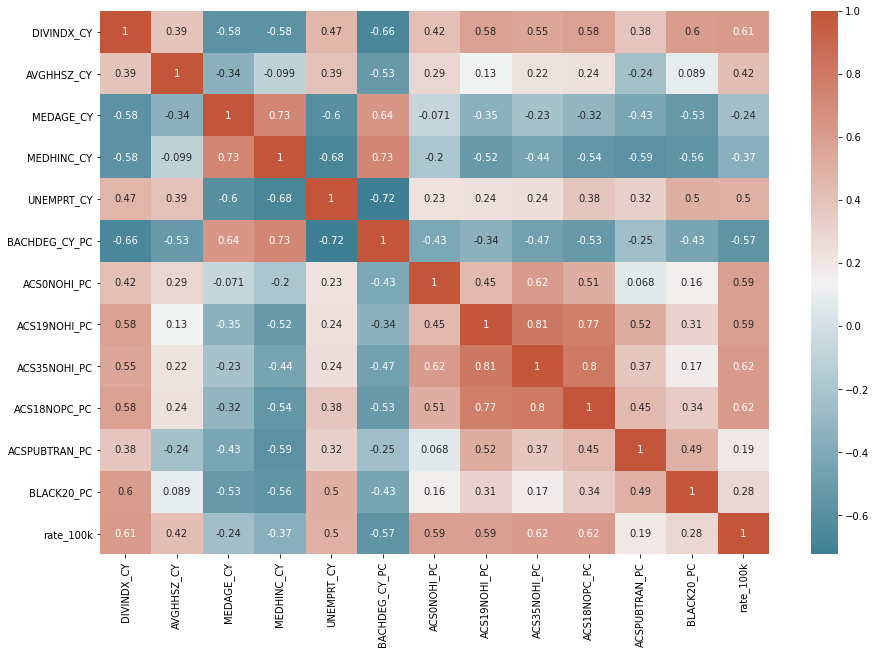

In [44]:
#COMPUTE CORRELATION MATRIX AND SHOW IT AS A HEATMAP,
import matplotlib.pyplot as plt
import seaborn as sns
corr = zip1_dataset.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot:>

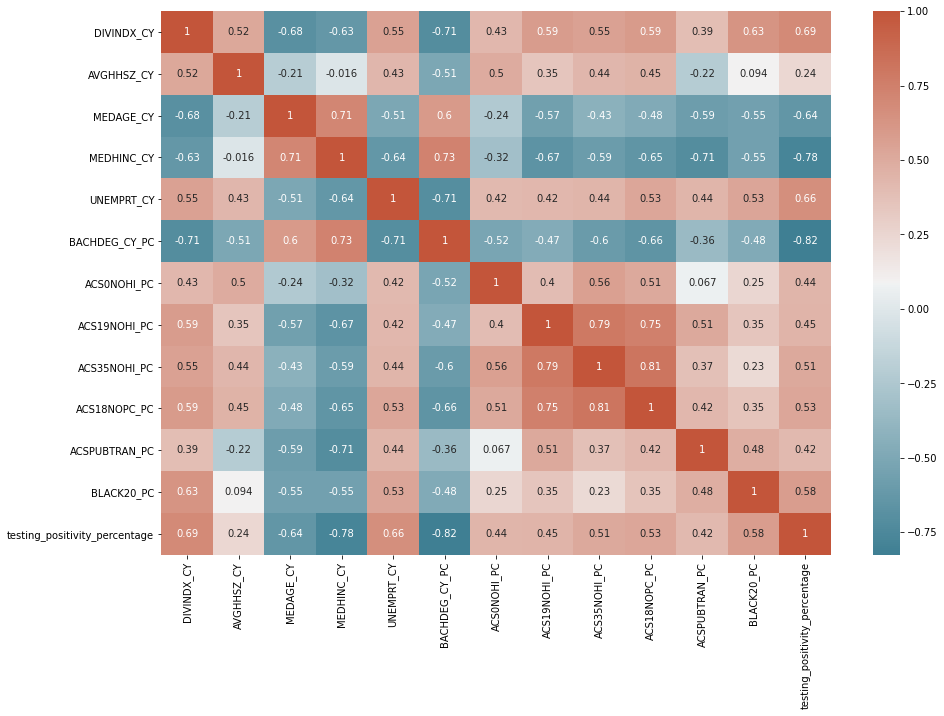

In [45]:
corr = zip2_dataset.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

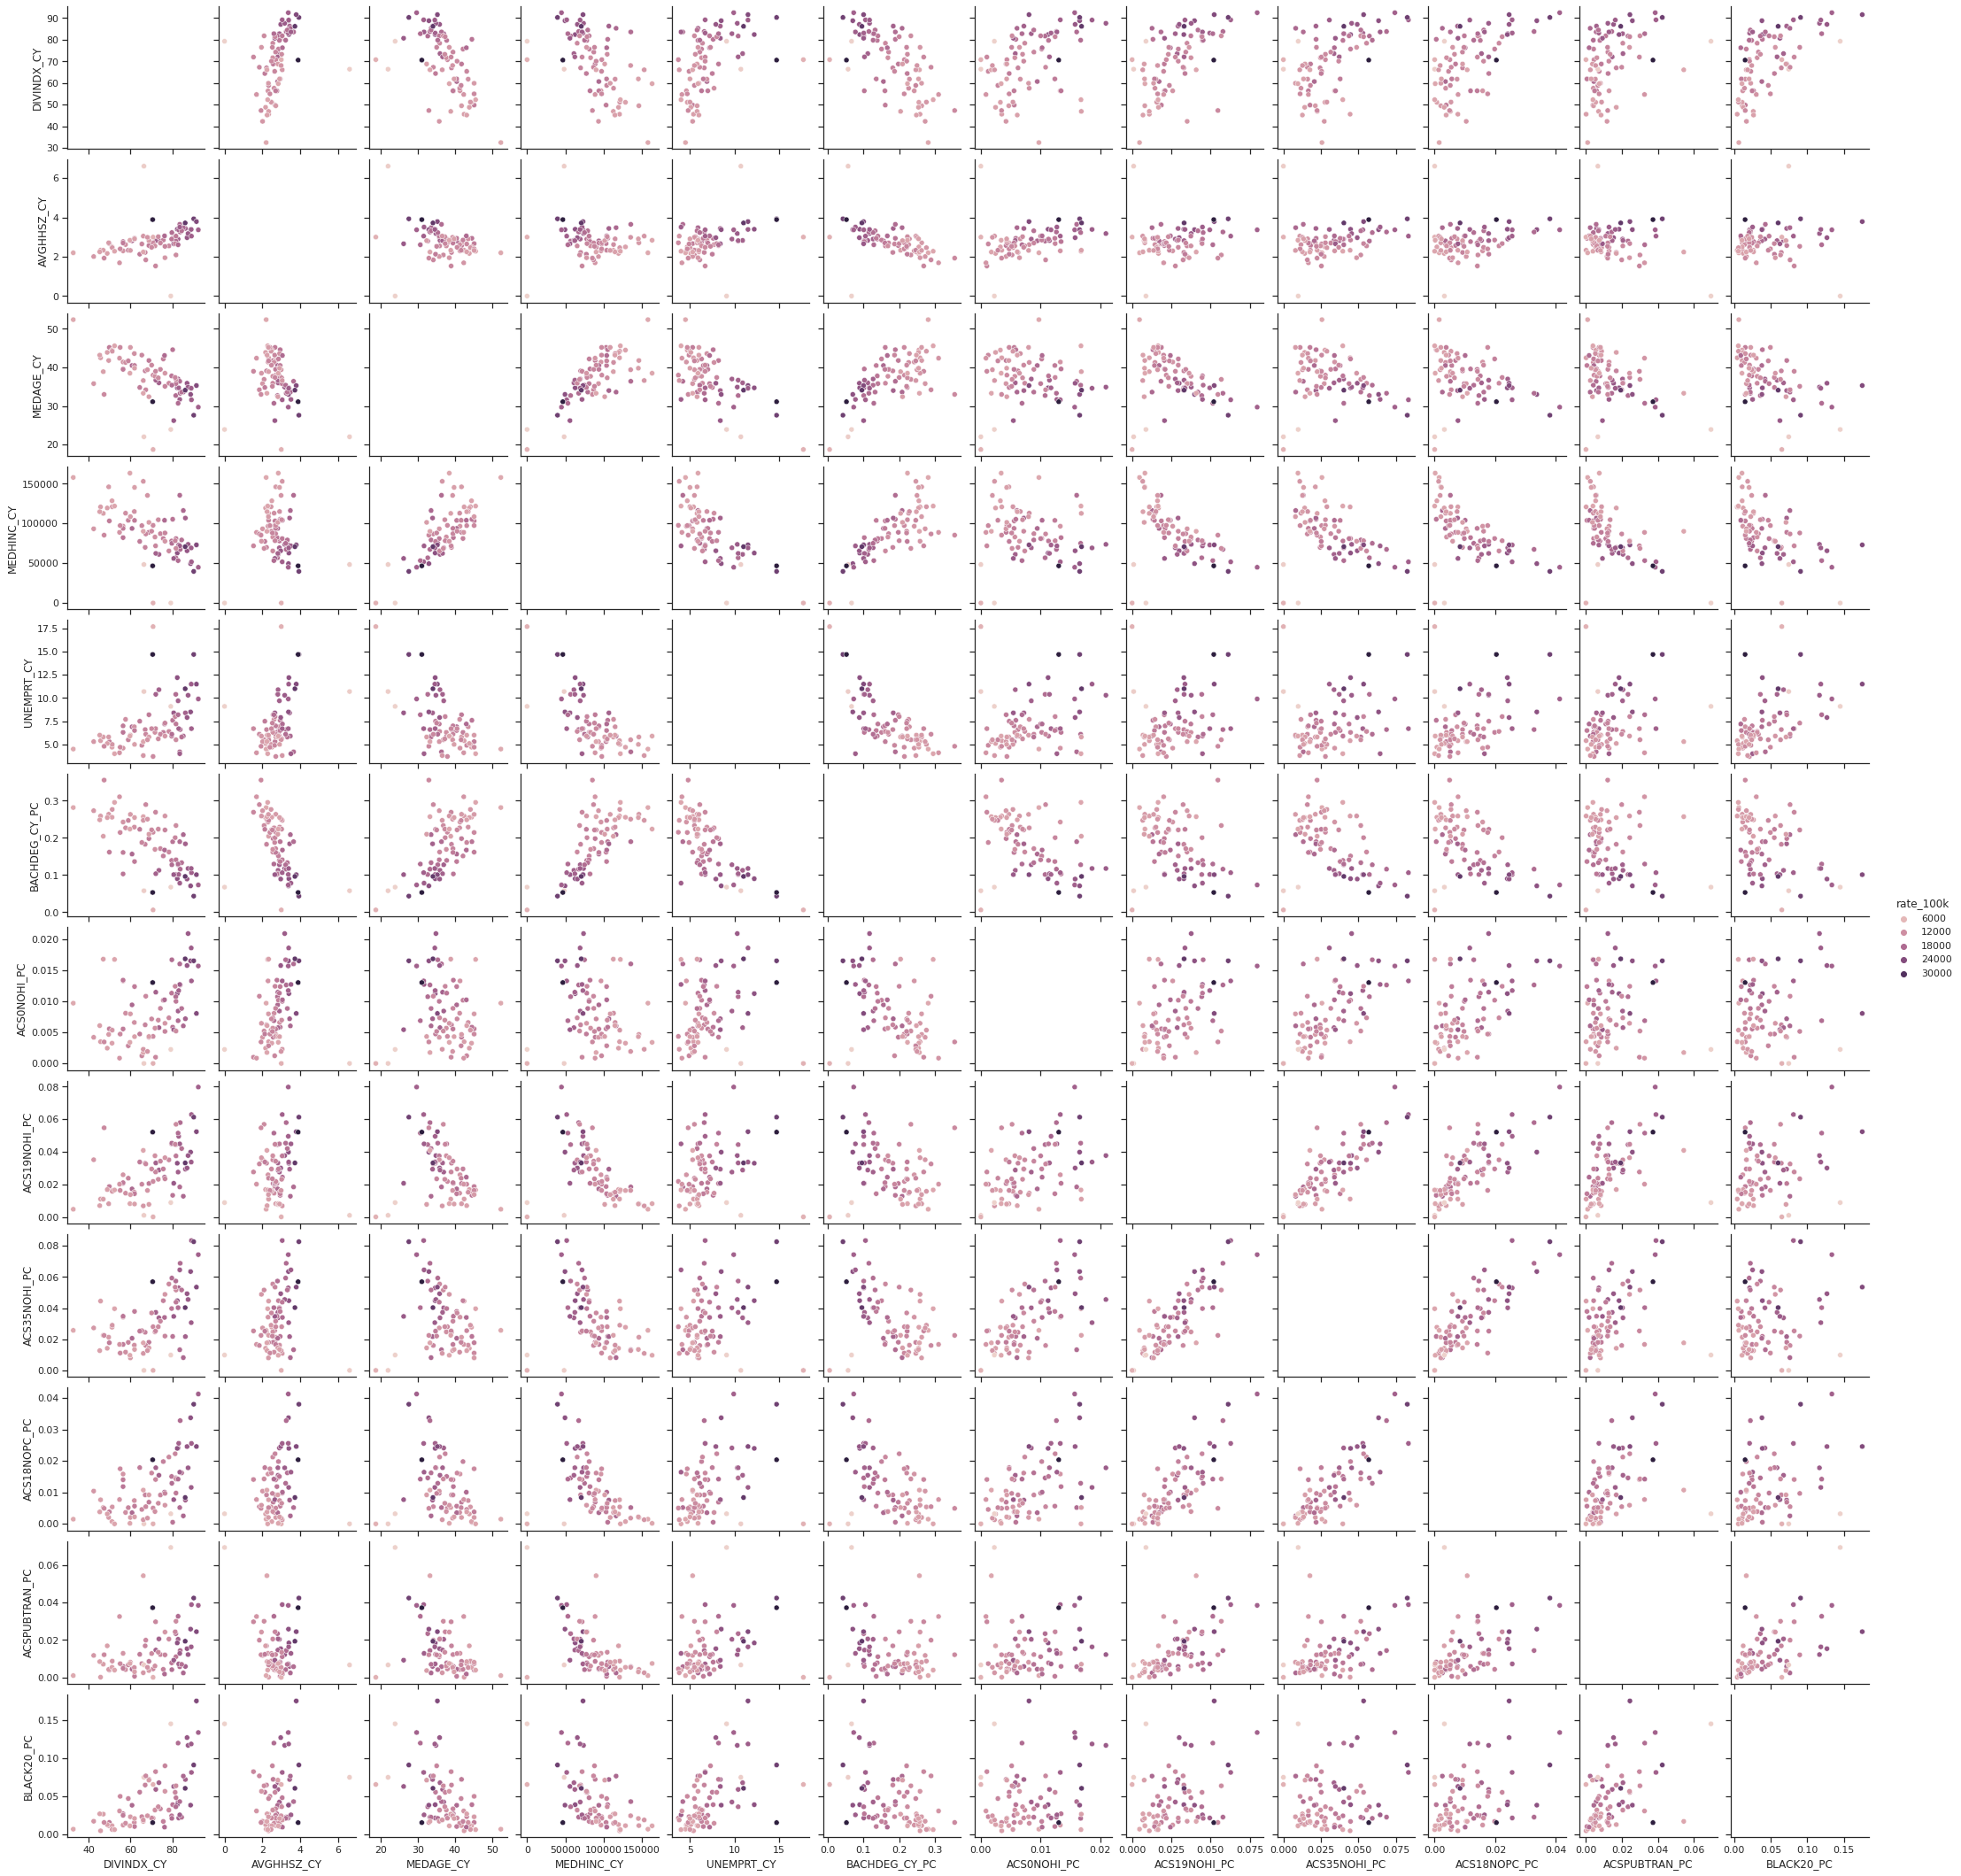

In [46]:
# EXPLORE PAIRWISE DISTRIBUTIONS
sns.set_theme(style="ticks")
sns.pairplot(zip1_dataset, hue='rate_100k')

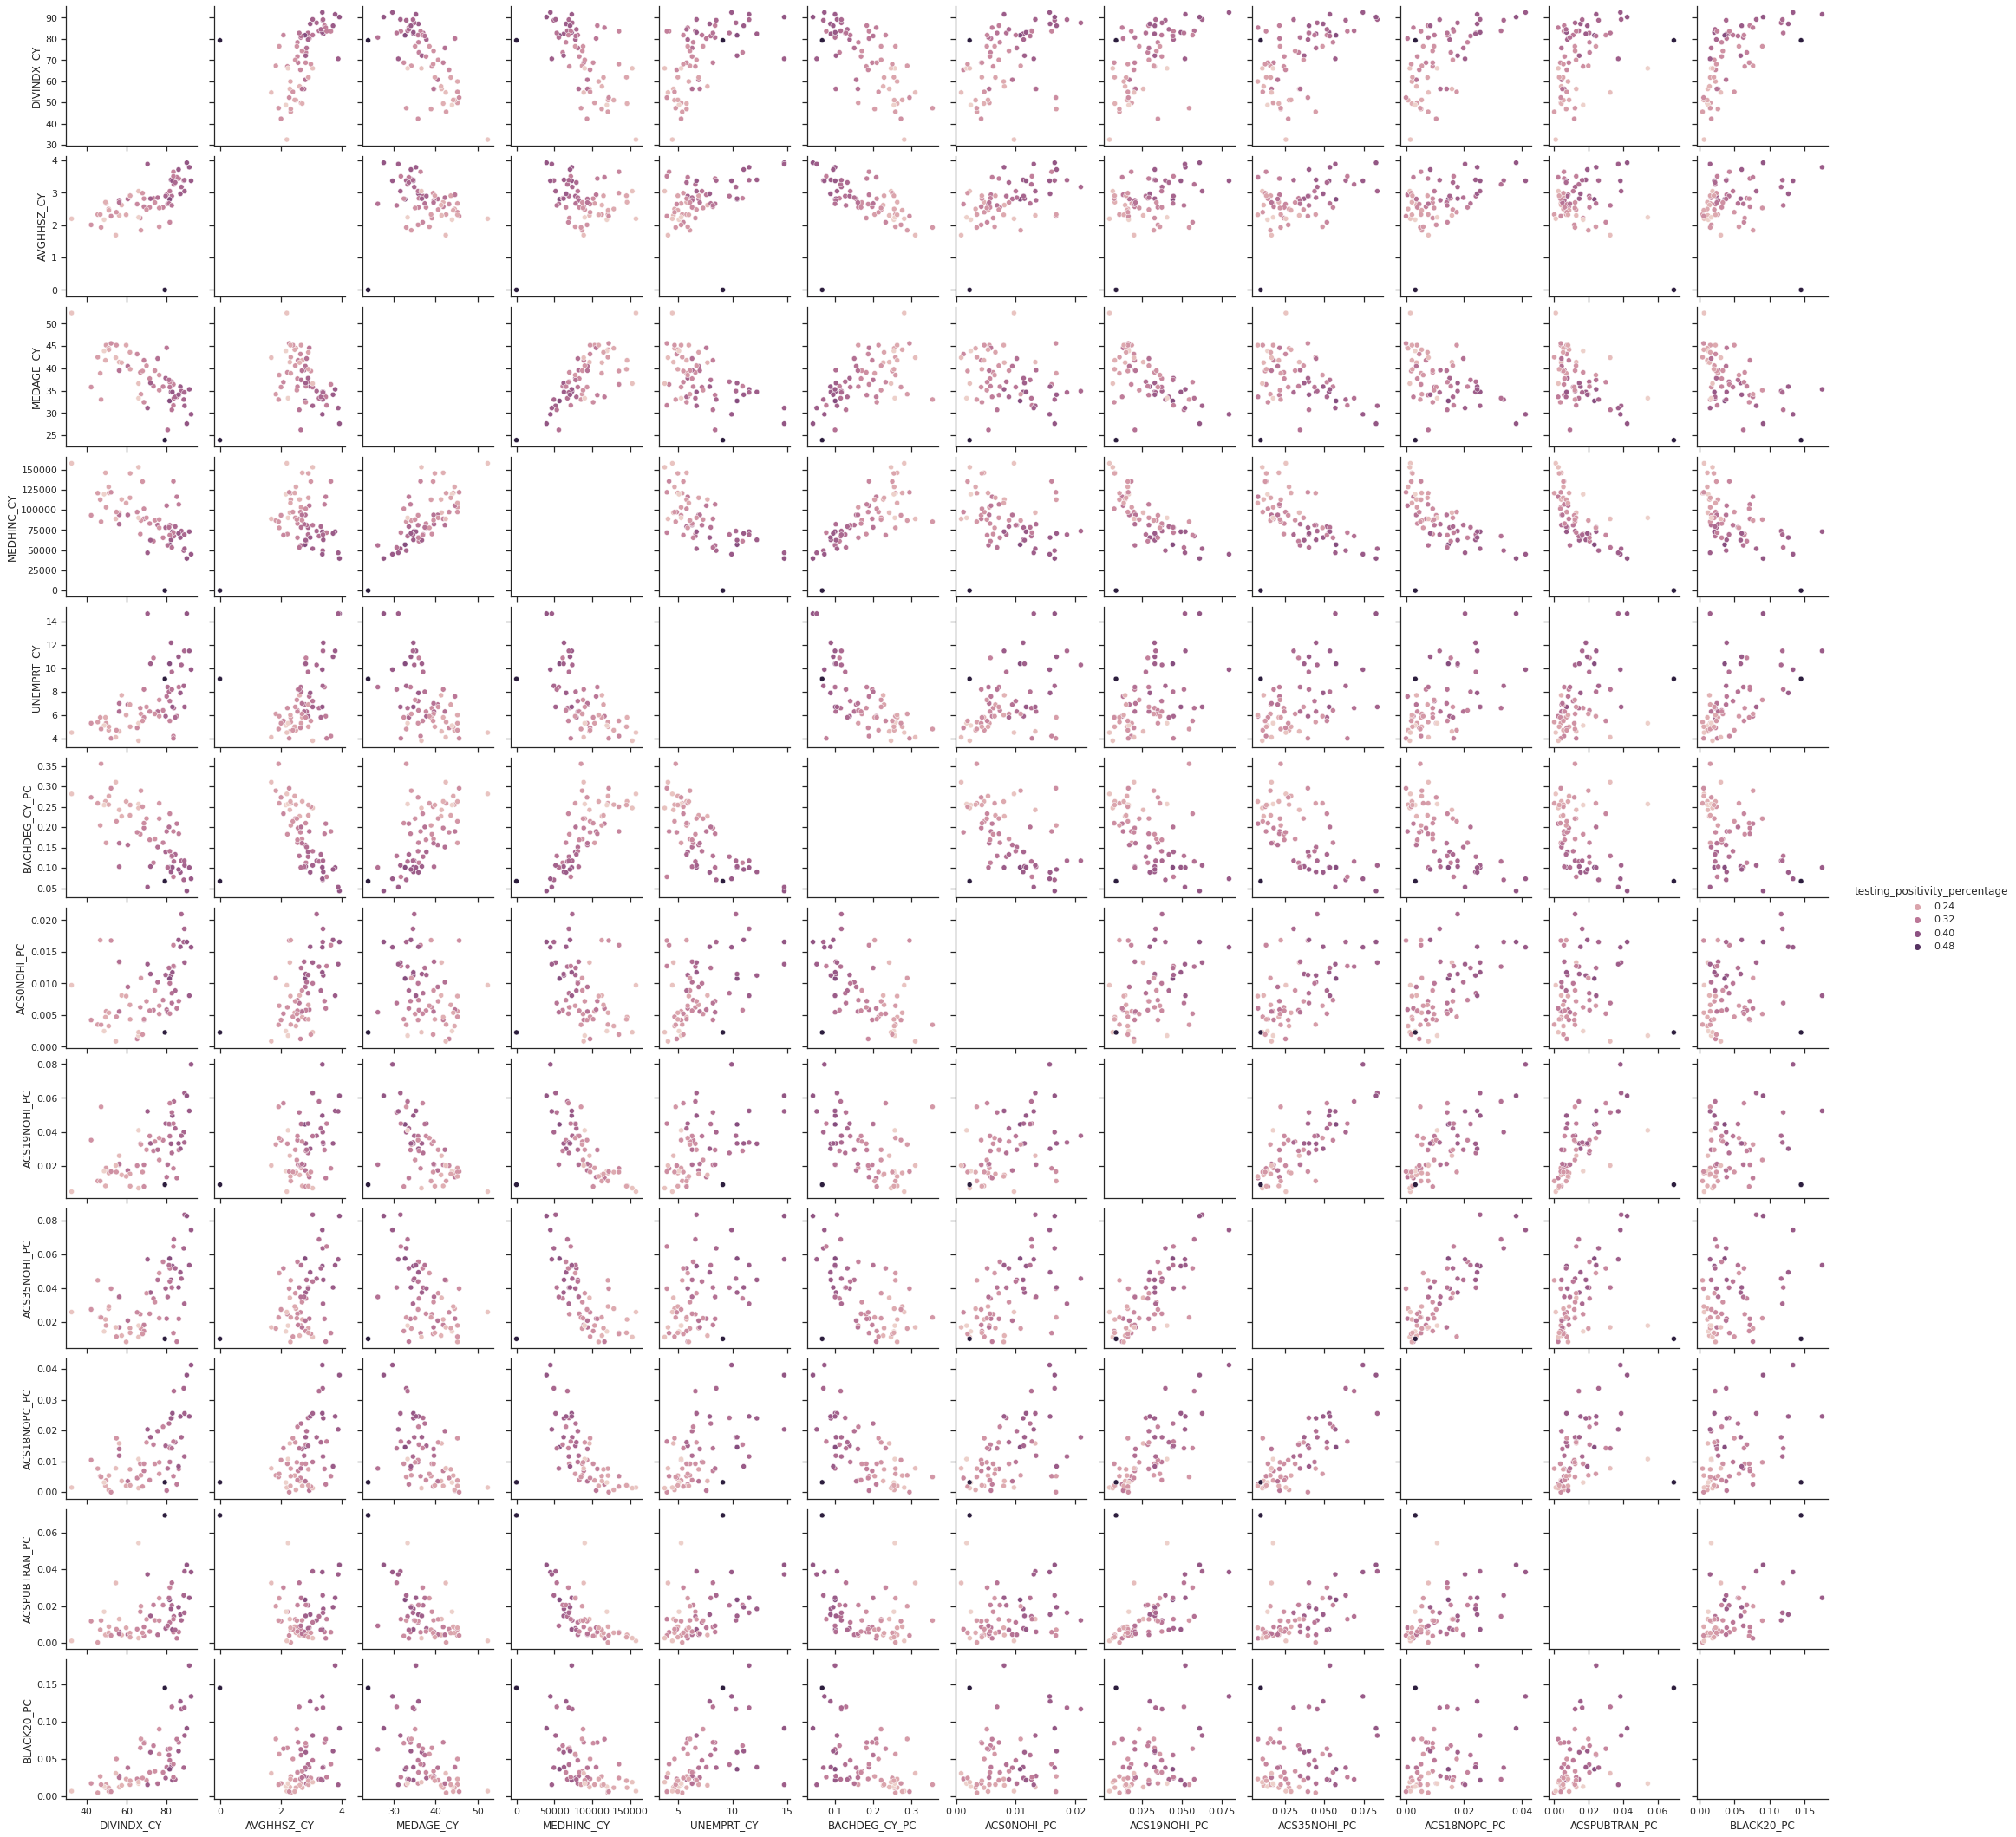

In [47]:
sns.set_theme(style="ticks")
sns.pairplot(zip2_dataset, hue='testing_positivity_percentage')

 NOTE ANY ABNORMALITIES, DROP SUSPECT VARIABLES.
None of these variables are too strongly correlated with one another, therefore we are not dropping any variables. 

## Step 3. Split the datasets into training and testing sets and run models

(15 points; follow prompts in CAPITAL LETTERS; This is where your additions (code, text) are expected)

### 3.1 Split the first dataset

In [48]:
from sklearn.model_selection import train_test_split

# to avoid randomness in train test split, we use a seed to generate the same random split everytime
seed = 12

In [49]:
# In the first dataset, we will be predicting rate_100k. It will be the 'y' series.
# The X (independent variables) will be all other variables in the dataset, except for rate_100k

# DEFINE THE y SERIES BY SELECTING THE rate_100k COLUMN FROM THE FIRST DATASET AND ASSIGNING IT TO y
# DEFINE THE X DATAFRAME BY DROPPING THE rate_100k COLUMN FROM THE FIRST DATASET AND ASSIGNING THE RESULT TO X

y = zip1_dataset['rate_100k']
X = zip1_dataset.drop(['rate_100k'], axis = 1)



In [50]:
# EXAMINE y and X AND MAKE SURE THEY LOOK CORRECT
print(y)
print(X)

0     14889.4
1     16266.8
2     19834.4
3     22748.4
4     19548.9
       ...   
73     9448.6
74     2393.7
75    20519.4
76    28166.4
77    34778.8
Name: rate_100k, Length: 78, dtype: float64
    DIVINDX_CY  AVGHHSZ_CY  MEDAGE_CY  MEDHINC_CY  UNEMPRT_CY  BACHDEG_CY_PC  \
0         49.8        2.67       45.2    103208.0         5.3       0.161434   
1         80.2        2.94       44.6    105293.0         7.6       0.189527   
2         82.8        2.90       37.0     69388.0         9.7       0.127533   
3         82.4        3.40       34.7     62811.0        12.2       0.090006   
4         86.3        3.44       34.0    106826.0         8.4       0.183764   
..         ...         ...        ...         ...         ...            ...   
73        61.9        2.91       39.8    145321.0         5.0       0.254453   
74        79.3        0.00       23.9         0.0         9.1       0.067348   
75        89.1        3.39       34.6     69225.0        11.5       0.117536   
76

In [51]:
# CREATE X_train, X_test, y_train, y_test USING train_test_split. 
# ALLOCATE 80% OF YOUR DATA TO THE TRAINING SET AND 20% TO THE TEST SET
# AS random_state, USE THE seed VARIABLE DEFINED ABOVE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

In [52]:
# EXPLORE X_train
X_train

,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,UNEMPRT_CY,BACHDEG_CY_PC,ACS0NOHI_PC,ACS19NOHI_PC,ACS35NOHI_PC,ACS18NOPC_PC,ACSPUBTRAN_PC,BLACK20_PC
50,92.5,3.37,29.7,44917.0,9.9,0.073223,0.015721,0.079739,0.074388,0.041308,0.038503,0.133603
74,79.3,0.00,23.9,0.0,9.1,0.067348,0.002257,0.008790,0.009859,0.003207,0.069486,0.145029
73,61.9,2.91,39.8,145321.0,5.0,0.254453,0.004320,0.007920,0.013440,0.002213,0.002933,0.020400
60,76.5,1.95,38.5,77678.0,5.9,0.258590,0.006472,0.036330,0.048867,0.005940,0.024230,0.056214
26,75.7,2.85,42.2,81108.0,6.3,0.151115,0.010196,0.029444,0.044799,0.019810,0.004275,0.016518
...,...,...,...,...,...,...,...,...,...,...,...,...
3,82.4,3.40,34.7,62811.0,12.2,0.090006,0.011267,0.032958,0.044813,0.024009,0.018405,0.038551
2,82.8,2.90,37.0,69388.0,9.7,0.127533,0.008451,0.027520,0.040215,0.024134,0.020351,0.042062
6,85.3,3.48,33.6,116255.0,5.9,0.208513,0.006054,0.012690,0.008195,0.002538,0.002355,0.076232
27,65.4,2.65,43.2,97274.0,4.9,0.187392,0.001232,0.020060,0.025531,0.004584,0.007344,0.022771


### 3.2 Import a regressor of your choce, fit the model, compute R2, examine feature importance



In [53]:
# IMPORT A REGRESSOR, INITIALIZE IT, FIT THE MODEL, COMPUTE AND PRINT THE SCORES
# (random forest regressor is recommended, but feel free to experiment)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=seed)
rf.fit(X_train, y_train)
r1 = rf.score(X_train, y_train)
r2 = rf.score(X_test, y_test)
print('R² of Random Forest Regressor on training set: {:.3f}'.format(r1))
print('R² of Random Forest Regressor on test set: {:.3f}'.format(r2))

R² of Random Forest Regressor on training set: 0.928
R² of Random Forest Regressor on test set: 0.792


<AxesSubplot:title={'center':'Feature importance'}>

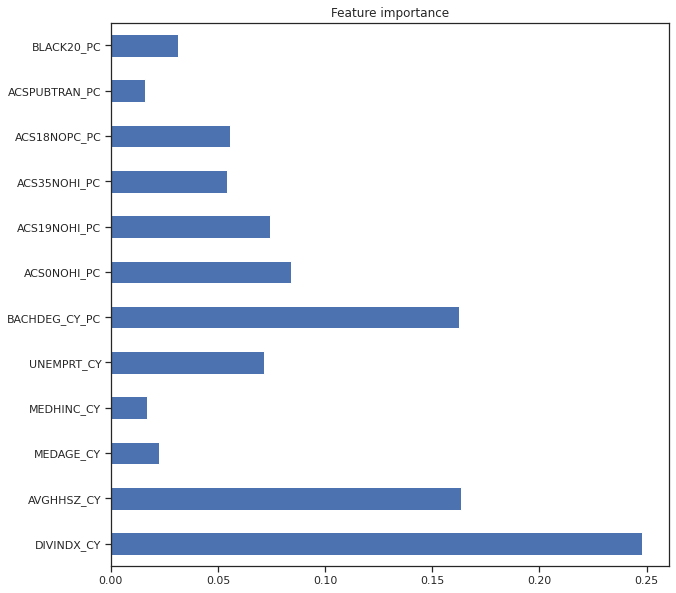

In [54]:
# EXAMINE FEATURE IMPORTANCES, AND PLOT THEM
labels = X.columns.values.tolist()
feat_importances = pd.Series(rf.feature_importances_, index=labels)
feat_importances.plot.barh(figsize=(10,10), title="Feature importance")

## Step 4 Model improvements

(20 points; follow prompts in CAPITAL LETTERS; This is where your additions (code, text) are expected)

In [55]:
# Let's apply standard scaling, and compare the model accuracies

# IMPORT AND INTIALIZE STANDARD SCALER
from sklearn.preprocessing import StandardScaler, LabelEncoder
sc = StandardScaler()


In [56]:
# APPLY STANDARD SCALER TO "X", NAME THE RESULT X_scaled 
X_scaled = sc.fit_transform(X)

In [57]:
X_scaled[:,0]

array([-1.44782134,  0.72845375,  0.91458254,  0.88594734,  1.16514053,
        0.97185294,  1.09355253,  0.83583575, -0.08764941, -0.2165078 ,
        1.22241093,  1.34411052,  1.25820493, -1.74849092, -0.97534056,
       -1.46929774, -0.88943497, -1.35475694, -2.68629367, -0.66751218,
        0.25597298,  0.14859098, -1.34759814,  0.98617054,  0.69265975,
        0.93605894,  0.40630777, -0.33104859, -1.51940933, -0.97534056,
        0.59959536, -0.2594606 ,  0.30608457,  0.84299455,  0.76424775,
       -0.58876538, -0.58160658,  1.03628214, -0.97534056, -1.26885135,
        0.05552659,  0.11995578,  0.44926057,  0.97185294,  0.69981855,
        0.05552659,  0.14143218,  1.37274572, -1.09704015,  0.84299455,
        1.60898611, -1.65542653, -1.98473131, -0.1950314 , -1.62679133,
       -0.40263659,  0.81435935,  1.45149252,  1.54455691,  0.91458254,
        0.46357817,  0.00541499, -1.77712612, -1.07556376, -0.79637057,
       -0.280937  ,  0.46357817, -0.08764941,  0.23449658, -0.28

In [58]:
# USING THE SAME SPLITTING PARAMETRS AS BEFORE, SPLIT THE X_scaled and y INTO TRAINING AND TESTING SETS
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = seed)

In [59]:
# RE-RUN THE REGRESSOR YOU USED EARLIER, ON THE X_train, y_train OBTAINED IN THE PREVIOUS CELL
# EXAMINE MODEL PERFORMANCE AND FEATURE IMPORTANCE
# IMPORT A REGRESSOR, INITIALIZE IT, FIT THE MODEL, COMPUTE AND PRINT THE SCORES
# (random forest regressor is recommended, but feel free to experiment)
rf = RandomForestRegressor(n_estimators=100, random_state=seed)
rf.fit(X_train, y_train)
r1 = rf.score(X_train, y_train)
r2 = rf.score(X_test, y_test)
print('R² of Random Forest Regressor on training set: {:.3f}'.format(r1))
print('R² of Random Forest Regressor on test set: {:.3f}'.format(r2))


R² of Random Forest Regressor on training set: 0.928
R² of Random Forest Regressor on test set: 0.793


<AxesSubplot:title={'center':'Feature importance'}>

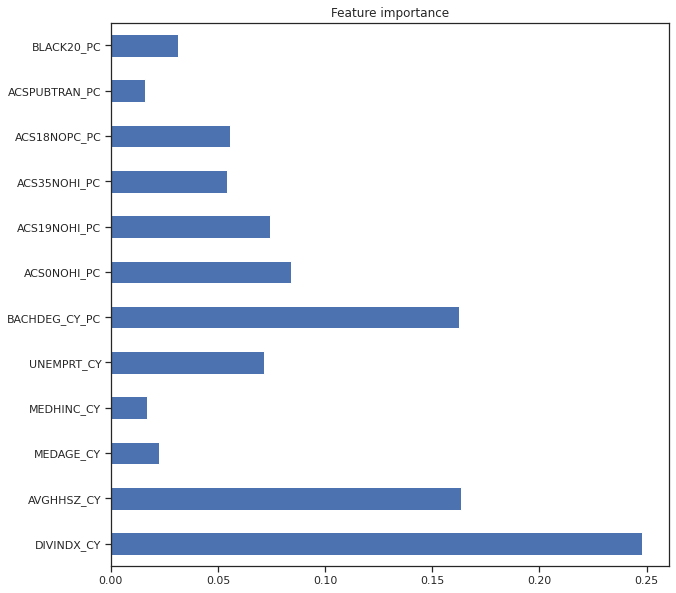

In [60]:
feat_importances = pd.Series(rf.feature_importances_, index=labels)
feat_importances.plot.barh(figsize=(10,10), title="Feature importance")

In [61]:
# FIGURE OUT WHICH VARIABLES HAVE LOW IMPORTANCE (possibly using SelectFromModel)
# A more regular way of generating a parsimonious model: use SelectFromModel
from sklearn.feature_selection import SelectFromModel
import numpy as np


threshold = np.sort(feat_importances)[-7] + 0.01
sfm = SelectFromModel(rf, threshold=threshold).fit(X, y)
sfm.get_support()


array([ True,  True, False, False,  True,  True, False,  True, False,
       False, False, False])

In [62]:
labels_selected = ['DIVINDX_CY', 'AVGHHSZ_CY', 'UNEMPRT_CY', 'BACHDEG_CY_PC', 'ACS19NOHI_PC']

### RE-RUN THE MODEL RETAINING ONLY 5-6 INDEPENDENT VARIABLES THAT ARE ABOVE THE IMPORTANCE THRESHOLD

Also, feel free to experiment with any additional improvements you can think of.

### DESCRIBE YOUR RESULTS AND MODEL IMPROVEMENTS YOU ATTEMPED

In [63]:
X = zip1_dataset[labels_selected] # Subsetting to top 5 most important variables
X_scaled = sc.fit_transform(X) # Setting standard scale
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = seed) # Setting train and test groups
rf.fit(X_train, y_train)
r1 = rf.score(X_train, y_train)
r2 = rf.score(X_test, y_test)
print('R² of Random Forest Regressor on training set: {:.3f}'.format(r1))
print('R² of Random Forest Regressor on test set: {:.3f}'.format(r2))
# We see that the training and test sets are closer together and still display high predictive power.
#THis is an improvement over the previous model. 



R² of Random Forest Regressor on training set: 0.912
R² of Random Forest Regressor on test set: 0.831


### REPEAT THE MODEL GENERATION AND ENHANCEMENT FOR THE SECOND DATASET, WHERE WE PREDICT POSITIVITY PERCENTAGE
(ANSWERING THE ABOVE PROMPTS SHOULD TAKE MULTIPLE CELLS)

In [64]:
X = zip2_dataset.drop(['testing_positivity_percentage'], axis=1)
y = zip2_dataset['testing_positivity_percentage']

In [65]:
rf2 = RandomForestRegressor(n_estimators=100, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed) # Setting train and test groups
rf2.fit(X_train, y_train)
r1 = rf2.score(X_train, y_train)
r2 = rf2.score(X_test, y_test)
print('R² of Random Forest Regressor on training set: {:.3f}'.format(r1))
print('R² of Random Forest Regressor on test set: {:.3f}'.format(r2))

R² of Random Forest Regressor on training set: 0.958
R² of Random Forest Regressor on test set: 0.636


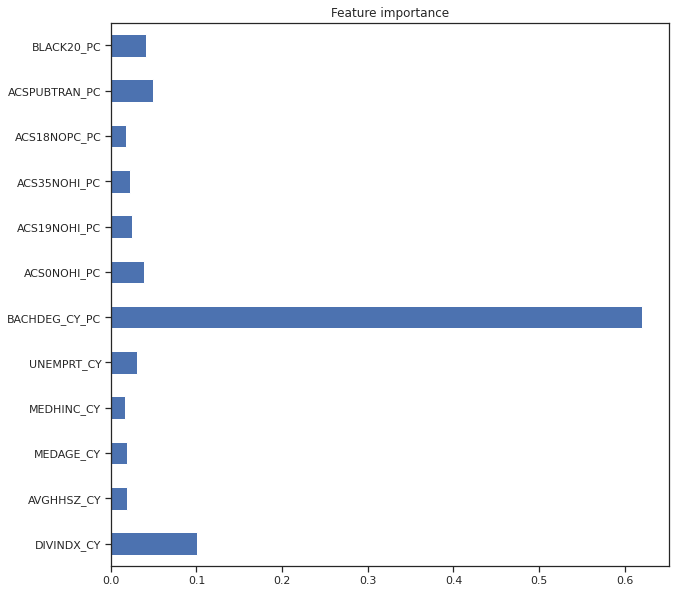

In [66]:
feat_importances = pd.Series(rf2.feature_importances_, index=labels)
feat_importances.plot.barh(figsize=(10,10), title="Feature importance")

threshold = np.sort(feat_importances)[-7] + 0.01
sfm = SelectFromModel(rf2, threshold=threshold).fit(X, y)
sfm.get_support()

labels_selected2 = ['DIVINDX_CY', 'UNEMPRT_CY', 'BACHDEG_CY_PC', 'ACS18NOPC_PC', 'ACSPUBTRAN_PC']

In [67]:
X = zip2_dataset[labels_selected2] # Subsetting to top 5 most important variables
X_scaled = sc.fit_transform(X) # Setting standard scale
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = seed) # Setting train and test groups
rf2.fit(X_train, y_train)
r1 = rf2.score(X_train, y_train)
r2 = rf2.score(X_test, y_test)
print('R² of Random Forest Regressor on training set: {:.3f}'.format(r1))
print('R² of Random Forest Regressor on test set: {:.3f}'.format(r2))

R² of Random Forest Regressor on training set: 0.958
R² of Random Forest Regressor on test set: 0.570


## Step 5. Create school service areas, for a subset of schools

(10 points; follow prompts in CAPITAL LETTERS; This is where your additions (code, text) are expected)

Now that we have at least two models (and one of them works better then the other or others), and we are satisfied with performance, we can approach our task of appying the best model to a new set of areas.

We will construct public school service areas based on a [fairly arbitrary] idea that the majority of students live within 8 min driving time of the school. This is generally consistent with SANDAG's estimates used in their transportation model, for urban schools. 


In [68]:
# retrieve public school data from a service mainatned by the state ot CA
public_school_URL = 'https://services3.arcgis.com/fdvHcZVgB2QSRNkL/ArcGIS/rest/services/SchoolSites2021/FeatureServer'

# CONVERT IT TO SEDF, AND NAME IT public_school_sedf

item = FeatureLayerCollection(public_school_URL, gis=gis)

public_school_sedf = pd.DataFrame.spatial.from_layer(item.layers[0])

### 5.1 Subsetting school data based on several conditions

Click the above service URL, then Info - Metadata, to examine the fields in this dataset.

1) the schools should have "Active" status and be not Excludively or Primarily Virtual

this translates into:

'Status' == 'Active' and

'Virtual' == 'N' or 'Virtual' == 'C' (i.e., not virtual schools, and schools with primarily classroom instruction)

(you will see these values explained in the metadata)

2) Only select schools in San Diego: 'CountyName' == 'San Diego'

3) Only select middle schools: 'SchoolLevel' =='Middle'

4) Only select real non-empty schools: 'EnrollTotal' > 0


In [69]:
# SUBSET THE SCHOOLS SEDF, APPLYING THE ABOVE CONDITIONS ONE BY ONE. MAY USE MULTIPLE CEL

# name the resultant SEDF "middle_school"

# here we provide one example for subsetting 'Status' to 'Active' and 'Virtual' to 'N' or 'C'
middle_school = public_school_sedf[(public_school_sedf['CountyName'] == 'San Diego') 
                                 & ((public_school_sedf['SchoolLevel'] == 'Middle') 
                                    & (public_school_sedf['EnrollTotal'] > 0))]



#2) Only select schools in San Diego: 'CountyName' == 'San Diego'

#3) Only select middle schools: 'SchoolLevel' =='Middle'

#4) Only select real non-empty schools: 'EnrollTotal' > 0


In [70]:
# Choose 5 schools from the first 50 schools in our middle school sedf (we provide the code)
import numpy as np
idx = np.random.choice(range(50), 5)
middle_school_subset = middle_school.iloc[idx]

In [71]:
middle_school_subset

,AAcount,AApct,AIcount,AIpct,AScount,ASpct,AssemblyCA,AssistStatusESSA,CDCode,CDSCode,Charter,CharterNum,City,ClosedDate,CongUS,CountyName,DASS,DistrictName,ELcount,ELpct,EnrollTotal,FIcount,FIpct,FOScount,FOSpct,FRPMcount,FRPMpct,FedID,FundingType,GradeHigh,GradeLow,HIcount,HIpct,HOMcount,HOMpct,Latitude,LocSource,Locale,Longitude,MIGcount,MIGpct,MRcount,MRpct,Magnet,NRcount,NRpct,OBJECTID,OpenDate,PIcount,PIpct,SCode,SEDCount,SEDpct,SHAPE,SWDcount,SWDpct,SchoolLevel,SchoolName,SchoolType,SenateCA,State,Status,Street,TitleIStatus,Virtual,WHcount,WHpct,Year,Zip
7093,23.0,1.5,2.0,0.1,614.0,39.2,77,None,3768296,37682960108332,N,None,San Diego,NaT,49,San Diego,N,Poway Unified,52.0,3.3,1566,93.0,5.9,0.0,0.0,143.0,9.1,063153011134,,08,06,122.0,7.8,21.0,1.3,33.00014,NCES,"21 - Suburban, Large",-117.10962,0.0,0.0,155.0,9.9,N,1.0,0.1,7094,2005-08-25,2.0,0.1,0108332,146.0,9.3,"{""x"": -13036583.265372816, ""y"": 3895322.546060...",145.0,9.3,Middle,Oak Valley Middle,Middle,38,CA,Active,16055 Winecreek Rd.,None,C,554.0,35.4,2020-21,92127
7311,26.0,3.7,3.0,0.4,15.0,2.1,78,None,3768338,37683386059596,N,None,San Diego,NaT,52,San Diego,N,San Diego Unified,41.0,5.9,699,7.0,1.0,0.0,0.0,199.0,28.5,063432005437,,08,07,203.0,29.0,14.0,2.0,32.74865,NCES,"11 - City, Large",-117.23192,0.0,0.0,69.0,9.9,N,2.0,0.3,7312,1980-07-01,2.0,0.3,6059596,206.0,29.5,"{""x"": -13050197.639159627, ""y"": 3861988.780986...",112.0,16.0,Middle,Correia Middle,Middle,39,CA,Active,4302 Valeta St.,None,N,372.0,53.2,2020-21,92107
7156,20.0,5.9,2.0,0.6,15.0,4.4,78,None,3768338,37683380107573,Y,0660,San Diego,NaT,52,San Diego,N,San Diego Unified,26.0,7.6,340,4.0,1.2,1.0,0.3,135.0,39.7,060187811155,Directly funded,08,06,166.0,48.8,1.0,0.3,32.73452,NCES,"11 - City, Large",-117.21984,0.0,0.0,25.0,7.4,N,0.0,0.0,7157,2005-09-06,4.0,1.2,0107573,139.0,40.9,"{""x"": -13048852.899709342, ""y"": 3860118.718091...",63.0,18.5,Middle,High Tech Middle Media Arts,Middle,39,CA,Active,"2230 Truxtun Rd., 2nd Fl.",None,N,104.0,30.6,2020-21,92106
6959,10.0,1.1,1.0,0.1,9.0,1.0,75,None,3768098,37680986038210,N,None,Escondido,NaT,50,San Diego,N,Escondido Union,369.0,41.9,880,5.0,0.6,6.0,0.7,823.0,93.5,061288001456,,08,06,827.0,94.0,64.0,7.3,33.13378,NCES,"21 - Suburban, Large",-117.07401,11.0,1.2,7.0,0.8,N,0.0,0.0,6960,1980-07-01,0.0,0.0,6038210,835.0,94.9,"{""x"": -13032619.178314112, ""y"": 3913074.513173...",116.0,13.2,Middle,Mission Middle,Middle,38,CA,Active,939 East Mission Ave.,None,N,21.0,2.4,2020-21,92026
7111,15.0,1.3,0.0,0.0,64.0,5.5,77,None,3768296,37682966070866,N,None,Poway,NaT,52,San Diego,N,Poway Unified,61.0,5.2,1164,23.0,2.0,0.0,0.0,236.0,20.3,063153004898,,08,06,279.0,24.0,42.0,3.6,32.97899,NCES,"13 - City, Small",-117.02914,0.0,0.0,132.0,11.3,N,5.0,0.4,7112,1980-07-01,1.0,0.1,6070866,249.0,21.4,"{""x"": -13027624.272823017, ""y"": 3892515.569223...",192.0,16.5,Middle,Twin Peaks Middle,Middle,38,CA,Active,14640 Tierra Bonita Rd.,None,C,645.0,55.4,2020-21,92064


In [72]:
# FOR EACH OF THE FIVE SELECTED MIDDLE SCHOOLS, COMPUTE 8-MIN DRIVE TIME BUFFERS. 
# IDEALLY, DO IT IN A LOOP, ACCUMULATING RESULTS IN A LIST

buffered = []
for i in middle_school_subset.SHAPE:
    buffers=BufferStudyArea(area=i, radii=[8], units="Minutes", travel_mode="Driving")
    buffered.append(buffers)
    
# here we provide a single example to buffer a single school (the first one)

#BufferStudyArea(area=middle_school_subset.SHAPE[0], radii=[8], units="Minutes", travel_mode="Driving")

In [73]:
buffered

[BufferStudyArea(area={'x': -13036583.265372816, 'y': 3895322.546060466, 'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}, radii=[8], units='Minutes', overlap=True, travel_mode='Driving'),
 BufferStudyArea(area={'x': -13050197.639159627, 'y': 3861988.780986734, 'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}, radii=[8], units='Minutes', overlap=True, travel_mode='Driving'),
 BufferStudyArea(area={'x': -13048852.899709342, 'y': 3860118.718091302, 'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}, radii=[8], units='Minutes', overlap=True, travel_mode='Driving'),
 BufferStudyArea(area={'x': -13032619.178314112, 'y': 3913074.5131738377, 'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}, radii=[8], units='Minutes', overlap=True, travel_mode='Driving'),
 BufferStudyArea(area={'x': -13027624.272823017, 'y': 3892515.569223058, 'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}, radii=[8], units='Minutes', overlap=True, travel_mode='Driving')]

## Step 6. Geoenrich school service areas, explore

(10 points; follow prompts in CAPITAL LETTERS; This is where your additions (code, text) are expected)

In [74]:
# CREATE middle_school_enriched SEDF, 
# BY ENRICHING THE ABOVE-CONSTRUCTED SERVICE AREAS 
# USING THE EXACT SET OF VARIABLES YOU USED IN MODEL CONSTRUCTION 


from arcgis.geoenrichment import *
columns=['TOTPOP_CY','DIVINDX_CY','AVGHHSZ_CY','MEDAGE_CY','MEDHINC_CY','BACHDEG_CY','ACS0NOHI','ACS19NOHI','ACS35NOHI','UNEMPRT_CY','ACS18NOPC','ACSPUBTRAN','BLACK20']

middle_school_enriched = enrich(study_areas=buffered, analysis_variables=columns)


In [75]:
middle_school_enriched

,ID,OBJECTID,sourceCountry,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP_CY,DIVINDX_CY,AVGHHSZ_CY,MEDAGE_CY,MEDHINC_CY,BACHDEG_CY,ACS0NOHI,ACS19NOHI,ACS35NOHI,UNEMPRT_CY,ACS18NOPC,ACSPUBTRAN,BLACK20,SHAPE
0,0,1,US,NetworkServiceArea,Minutes,Drive Time Minutes,8,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,73283,66.8,2.90,38.6,130399,18390,337,979,1091,5.0,158,438,1735,"{""rings"": [[[-117.07262823634369, 33.052882034..."
1,1,2,US,NetworkServiceArea,Minutes,Drive Time Minutes,8,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,47143,51.8,2.07,36.6,90754,11312,440,1489,1397,6.1,695,459,1437,"{""rings"": [[[-117.2361208697568, 32.7809183259..."
2,2,3,US,NetworkServiceArea,Minutes,Drive Time Minutes,8,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,76636,54.1,2.03,36.2,91230,17753,558,2001,1853,5.9,914,941,2772,"{""rings"": [[[-117.21343851213904, 32.804723572..."
3,3,4,US,NetworkServiceArea,Minutes,Drive Time Minutes,8,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,129628,84.6,3.24,32.9,61211,11893,1779,7822,8132,6.8,3801,1410,3133,"{""rings"": [[[-117.1186666826524, 33.1862812430..."
4,4,5,US,NetworkServiceArea,Minutes,Drive Time Minutes,8,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,62767,63.3,2.74,42.0,113483,15122,490,928,956,6.1,370,452,1116,"{""rings"": [[[-117.02344569911696, 33.034915810..."


In [209]:
#middle_school_enriched = middle_school_enriched.drop(1)

In [76]:
# CREATE A MAP WIDGET AND PLOT THE ENRICHED AREAS
import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import FeatureLayerCollection
from arcgis.features import GeoAccessor, GeoSeriesAccessor # this is a component for working with SEDF

ms_map = middle_school_enriched.spatial

In [77]:
buffer_map = gis.map('San Diego, CA')
buffer_map.basemap = 'dark-gray-vector'
buffer_map

MapView(layout=Layout(height='400px', width='100%'))

In [78]:
ms_map.plot(map_widget=buffer_map,
                   renderer_type='c',  # for class breaks renderer
                   method='esriClassifyNaturalBreaks',  # classification algorithm
                   class_count=3,  # choose the number of classes
                   col='bufferRadii',  # numeric column to classify
                   cmap='viridis',  # color map to pick colors from for each class
                   alpha=0.7  # specify opacity
                   )

True

## Step 7. Apply the ML model to determine the target COVID characteristics by school service areas

(20 points; follow prompts in CAPITAL LETTERS; This is where your additions (code, text) are expected)

### 7.1 Construct a normalized set of variables, as before. Then drop variables we no longer need.

In [99]:
# PREPARE THE INDEPENDENT VARIABLES BY THE 5 SCHOOL SERVICE AREAS
# USE THE PROCEDURES FOR NORMALIZATION, SCALING, ETC. THAT YOU USED EARLIER WHEN PREPARING DATA FOR MODELING
# DROP THOSE VARIABLES YOU DON'T NEED (e.g., Total population, zip code)
# THE RESULTS SHOULD BE IN DATAFRAME NAMED X_pred
# MAKE SURE YOU HAVE THE EXACT SAME LIST OF VARIABLES YOU USED IN X or X_scaled
middle_school_enriched = middle_school_enriched[columns]

loop = ['BACHDEG_CY','ACS0NOHI','ACS19NOHI','ACS35NOHI', 'ACS18NOPC', 'ACSPUBTRAN', 'BLACK20']
    
middle_school_enriched = middle_school_enriched.astype('float')
for i in loop:
    middle_school_enriched[i+'_PC'] = middle_school_enriched[i]/middle_school_enriched['TOTPOP_CY']
    
# (may do this in multiple cells)


In [100]:
middle_school = middle_school_enriched.drop(['TOTPOP_CY', 'BACHDEG_CY','ACS0NOHI','ACS19NOHI','ACS35NOHI', 'ACS18NOPC', 'ACSPUBTRAN', 'BLACK20'], axis=1)


In [101]:
middle_school_filtered = middle_school[labels_selected].dropna()
sc = StandardScaler()
X_scaled = sc.fit_transform(middle_school_filtered)
X_scaled[:,0]
#X_pred = middle_school_filtered

array([ 0.22989805, -1.05684478, -0.85954421,  1.75683288, -0.07034194])

In [102]:
#middle_school_filtered

In [103]:
X_scaled

array([[ 0.22989805,  0.64091106, -1.69673123,  0.66544546, -0.93434113],
       [-1.05684478, -1.1089448 ,  0.20776301,  0.48209157,  0.13820761],
       [-0.85954421, -1.1932752 , -0.13850867,  0.34371521, -0.18394738],
       [ 1.75683288,  1.35771948,  1.41971389, -1.98955403,  1.83052346],
       [-0.07034194,  0.30358945,  0.20776301,  0.49830179, -0.85044256]])

### 7.2. Once you constructed a feature set for prediction (X_pred), use rf.predict to run the model

In [104]:
# AS THE OUTPUT, YOU WILL GET A LIST OF COVID RATES FOR THE 5 SCHOOLS
X_pred = X_scaled
pred = rf.predict(X_pred)

In [105]:
pred

array([13848.571, 14401.302, 14315.216, 25681.771, 13238.018])

### 7.3 Compare your predicted results for schools with COVID rates for the zip codes that the schools are in

In [106]:
# FIGURE OUT ZIP CODES FOR YOUR 5 SCHOOLS
# LOOK UP COVID RATES FOR THESE ZIP CODES
# COMPARE THEM WITH THE RATES FOR SCHOOL SERVICE AREAS YOU OBTAINED THROUGH MODELING

middle_school_subset["rate_100k_pred"] = pred
middle_school_subset

# (may take several cells)

,AAcount,AApct,AIcount,AIpct,AScount,ASpct,AssemblyCA,AssistStatusESSA,CDCode,CDSCode,Charter,CharterNum,City,ClosedDate,CongUS,CountyName,DASS,DistrictName,ELcount,ELpct,EnrollTotal,FIcount,FIpct,FOScount,FOSpct,FRPMcount,FRPMpct,FedID,FundingType,GradeHigh,GradeLow,HIcount,HIpct,HOMcount,HOMpct,Latitude,LocSource,Locale,Longitude,MIGcount,MIGpct,MRcount,MRpct,Magnet,NRcount,NRpct,OBJECTID,OpenDate,PIcount,PIpct,SCode,SEDCount,SEDpct,SHAPE,SWDcount,SWDpct,SchoolLevel,SchoolName,SchoolType,SenateCA,State,Status,Street,TitleIStatus,Virtual,WHcount,WHpct,Year,Zip,rate_100k_pred
7093,23.0,1.5,2.0,0.1,614.0,39.2,77,None,3768296,37682960108332,N,None,San Diego,NaT,49,San Diego,N,Poway Unified,52.0,3.3,1566,93.0,5.9,0.0,0.0,143.0,9.1,063153011134,,08,06,122.0,7.8,21.0,1.3,33.00014,NCES,"21 - Suburban, Large",-117.10962,0.0,0.0,155.0,9.9,N,1.0,0.1,7094,2005-08-25,2.0,0.1,0108332,146.0,9.3,"{""x"": -13036583.265372816, ""y"": 3895322.546060...",145.0,9.3,Middle,Oak Valley Middle,Middle,38,CA,Active,16055 Winecreek Rd.,None,C,554.0,35.4,2020-21,92127,13848.571
7311,26.0,3.7,3.0,0.4,15.0,2.1,78,None,3768338,37683386059596,N,None,San Diego,NaT,52,San Diego,N,San Diego Unified,41.0,5.9,699,7.0,1.0,0.0,0.0,199.0,28.5,063432005437,,08,07,203.0,29.0,14.0,2.0,32.74865,NCES,"11 - City, Large",-117.23192,0.0,0.0,69.0,9.9,N,2.0,0.3,7312,1980-07-01,2.0,0.3,6059596,206.0,29.5,"{""x"": -13050197.639159627, ""y"": 3861988.780986...",112.0,16.0,Middle,Correia Middle,Middle,39,CA,Active,4302 Valeta St.,None,N,372.0,53.2,2020-21,92107,14401.302
7156,20.0,5.9,2.0,0.6,15.0,4.4,78,None,3768338,37683380107573,Y,0660,San Diego,NaT,52,San Diego,N,San Diego Unified,26.0,7.6,340,4.0,1.2,1.0,0.3,135.0,39.7,060187811155,Directly funded,08,06,166.0,48.8,1.0,0.3,32.73452,NCES,"11 - City, Large",-117.21984,0.0,0.0,25.0,7.4,N,0.0,0.0,7157,2005-09-06,4.0,1.2,0107573,139.0,40.9,"{""x"": -13048852.899709342, ""y"": 3860118.718091...",63.0,18.5,Middle,High Tech Middle Media Arts,Middle,39,CA,Active,"2230 Truxtun Rd., 2nd Fl.",None,N,104.0,30.6,2020-21,92106,14315.216
6959,10.0,1.1,1.0,0.1,9.0,1.0,75,None,3768098,37680986038210,N,None,Escondido,NaT,50,San Diego,N,Escondido Union,369.0,41.9,880,5.0,0.6,6.0,0.7,823.0,93.5,061288001456,,08,06,827.0,94.0,64.0,7.3,33.13378,NCES,"21 - Suburban, Large",-117.07401,11.0,1.2,7.0,0.8,N,0.0,0.0,6960,1980-07-01,0.0,0.0,6038210,835.0,94.9,"{""x"": -13032619.178314112, ""y"": 3913074.513173...",116.0,13.2,Middle,Mission Middle,Middle,38,CA,Active,939 East Mission Ave.,None,N,21.0,2.4,2020-21,92026,25681.771
7111,15.0,1.3,0.0,0.0,64.0,5.5,77,None,3768296,37682966070866,N,None,Poway,NaT,52,San Diego,N,Poway Unified,61.0,5.2,1164,23.0,2.0,0.0,0.0,236.0,20.3,063153004898,,08,06,279.0,24.0,42.0,3.6,32.97899,NCES,"13 - City, Small",-117.02914,0.0,0.0,132.0,11.3,N,5.0,0.4,7112,1980-07-01,1.0,0.1,6070866,249.0,21.4,"{""x"": -13027624.272823017, ""y"": 3892515.569223...",192.0,16.5,Middle,Twin Peaks Middle,Middle,38,CA,Active,14640 Tierra Bonita Rd.,None,C,645.0,55.4,2020-21,92064,13238.018


In [107]:
# Adding back in original rate_100k from 'sedf_zip1_filtered' to compare with model predictions:
sedf_zip1_filtered = sedf_zip1_filtered.rename(columns={'Zip_Code': 'Zip'})
middle_school_final = pd.merge(middle_school_subset,sedf_zip1_filtered[['Zip','rate_100k']],on='Zip', how='left')
middle_school_final = middle_school_final.rename(columns={"rate_100k": "rate_100k_actual"})
middle_school_final

,AAcount,AApct,AIcount,AIpct,AScount,ASpct,AssemblyCA,AssistStatusESSA,CDCode,CDSCode,Charter,CharterNum,City,ClosedDate,CongUS,CountyName,DASS,DistrictName,ELcount,ELpct,EnrollTotal,FIcount,FIpct,FOScount,FOSpct,FRPMcount,FRPMpct,FedID,FundingType,GradeHigh,GradeLow,HIcount,HIpct,HOMcount,HOMpct,Latitude,LocSource,Locale,Longitude,MIGcount,MIGpct,MRcount,MRpct,Magnet,NRcount,NRpct,OBJECTID,OpenDate,PIcount,PIpct,SCode,SEDCount,SEDpct,SHAPE,SWDcount,SWDpct,SchoolLevel,SchoolName,SchoolType,SenateCA,State,Status,Street,TitleIStatus,Virtual,WHcount,WHpct,Year,Zip,rate_100k_pred,rate_100k_actual
0,23.0,1.5,2.0,0.1,614.0,39.2,77,None,3768296,37682960108332,N,None,San Diego,NaT,49,San Diego,N,Poway Unified,52.0,3.3,1566,93.0,5.9,0.0,0.0,143.0,9.1,063153011134,,08,06,122.0,7.8,21.0,1.3,33.00014,NCES,"21 - Suburban, Large",-117.10962,0.0,0.0,155.0,9.9,N,1.0,0.1,7094,2005-08-25,2.0,0.1,0108332,146.0,9.3,"{'x': -13036583.265372816, 'y': 3895322.546060...",145.0,9.3,Middle,Oak Valley Middle,Middle,38,CA,Active,16055 Winecreek Rd.,None,C,554.0,35.4,2020-21,92127,13848.571,10735.0
1,26.0,3.7,3.0,0.4,15.0,2.1,78,None,3768338,37683386059596,N,None,San Diego,NaT,52,San Diego,N,San Diego Unified,41.0,5.9,699,7.0,1.0,0.0,0.0,199.0,28.5,063432005437,,08,07,203.0,29.0,14.0,2.0,32.74865,NCES,"11 - City, Large",-117.23192,0.0,0.0,69.0,9.9,N,2.0,0.3,7312,1980-07-01,2.0,0.3,6059596,206.0,29.5,"{'x': -13050197.639159627, 'y': 3861988.780986...",112.0,16.0,Middle,Correia Middle,Middle,39,CA,Active,4302 Valeta St.,None,N,372.0,53.2,2020-21,92107,14401.302,10768.1
2,20.0,5.9,2.0,0.6,15.0,4.4,78,None,3768338,37683380107573,Y,0660,San Diego,NaT,52,San Diego,N,San Diego Unified,26.0,7.6,340,4.0,1.2,1.0,0.3,135.0,39.7,060187811155,Directly funded,08,06,166.0,48.8,1.0,0.3,32.73452,NCES,"11 - City, Large",-117.21984,0.0,0.0,25.0,7.4,N,0.0,0.0,7157,2005-09-06,4.0,1.2,0107573,139.0,40.9,"{'x': -13048852.899709342, 'y': 3860118.718091...",63.0,18.5,Middle,High Tech Middle Media Arts,Middle,39,CA,Active,"2230 Truxtun Rd., 2nd Fl.",None,N,104.0,30.6,2020-21,92106,14315.216,9365.6
3,10.0,1.1,1.0,0.1,9.0,1.0,75,None,3768098,37680986038210,N,None,Escondido,NaT,50,San Diego,N,Escondido Union,369.0,41.9,880,5.0,0.6,6.0,0.7,823.0,93.5,061288001456,,08,06,827.0,94.0,64.0,7.3,33.13378,NCES,"21 - Suburban, Large",-117.07401,11.0,1.2,7.0,0.8,N,0.0,0.0,6960,1980-07-01,0.0,0.0,6038210,835.0,94.9,"{'x': -13032619.178314112, 'y': 3913074.513173...",116.0,13.2,Middle,Mission Middle,Middle,38,CA,Active,939 East Mission Ave.,None,N,21.0,2.4,2020-21,92026,25681.771,15899.6
4,15.0,1.3,0.0,0.0,64.0,5.5,77,None,3768296,37682966070866,N,None,Poway,NaT,52,San Diego,N,Poway Unified,61.0,5.2,1164,23.0,2.0,0.0,0.0,236.0,20.3,063153004898,,08,06,279.0,24.0,42.0,3.6,32.97899,NCES,"13 - City, Small",-117.02914,0.0,0.0,132.0,11.3,N,5.0,0.4,7112,1980-07-01,1.0,0.1,6070866,249.0,21.4,"{'x': -13027624.272823017, 'y': 3892515.569223...",192.0,16.5,Middle,Twin Peaks Middle,Middle,38,CA,Active,14640 Tierra Bonita Rd.,None,C,645.0,55.4,2020-21,92064,13238.018,11655.9


In [108]:
# check if your prediction makes sense with respect to values of COVID rates by respective zip codes
# zip2_dataset[zip2_dataset['ZIP'].isin(middle_school_subset.Zip.to_list())]

# I did this in above code

### DISCUSS YOUR RESULTS. WHAT DO YOU THINK ARE THE CAVEATS WITH THE APPROACH WE TOOK HERE?

Generally speaking, the model overestimates COVID rates. One caveat we have with this model is that there is not much data to use in the training set. Additionally, though we train on zip codes, we apply the model to geographies buffered around middle schools. We do not know how well these buffered geographies correlate with the zip codes in the training set. The model may perform better if it was trained on the middle school geographies rather than on zip code geographies. 